# Espresso extraction analysis

many thanks to stephane ribes who has thoughtfully and precisely logged his espresso data for the past two ish years!

## Writeup (TODO)  

#### methods


#### results

#### limitations
- briefly, there are many!  
- standard issues with observational data make it difficult to establish causality, e.g. https://doi.org/10.1016/j.therap.2018.11.001 - only possible if we assume we've captured the true data-generating process ( http://causality.cs.ucla.edu/blog/index.php/category/back-door-criterion/ )    
- (e.g. common causes, missing causes, colliders...)  
- technique improvement over years - I added a variable for this but not going to be perfect  
- earlier extractions had mysteriously high EY that trended down before trending up - why?  
- missing variables - presumably, we're missing many of the variables that matter here, excluding the exception cases, R2 = .65 ish which is perfectly decently but not super high.  


### Boilerplate

In [2]:
# Jan boilerplate, rev 2019/07/24

from datetime import date, datetime
import os
import sys
import pprint
import gc

import numpy as np
import pandas as pd

import scipy as sp
import scipy.stats

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import sklearn as skl

import pymc3 as pm

#import xgboost as xgb

# This notebook expects Python 3.
assert(sys.version_info >= (3, 4))

print(f'Python version: {sys.version}')
pd.show_versions()
print('Working directory: ', os.getcwd())
print(f'Current time {datetime.now()}')

# Display more rows, columns
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 80)
pd.set_option('display.width', 140)

# Auto reload extensions before executing, 
#   so we can edit references without restarting kernel.
#%load_ext autoreload
#%autoreload 2

# Print everything without requiring print statements.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Wide window (fill up screen horizontally)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


# # # Graph styling

# big graphs
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_context('talk')
sns.set_palette('GnBu')
sns.set_style('whitegrid')
# fix palette
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10.6, 6)
# fonts
plt.rcParams['font.sans-serif'] = ['Univers LT Std 55 Roman', 'Frutiger CE 55 Roman', 'SchulbuchNord Normal', 'Helvetica', 'sans-serif']
plt.rcParams['font.serif'] = ['Optima', 'serif']
plt.rcParams['font.monospace'] = ['Roboto Mono']
plt.rcParams['font.family'] = "sans-serif"
# big text
font = {'family' : 'sans-serif',
        'weight' : 'regular',
        'size'   : 16}
plt.rc('font', **font)
# slightly thinner linewidth, smaller markers
mpl.rcParams['lines.linewidth'] = 2.0
mpl.rcParams['lines.markersize'] = 6
# background
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
# plot colors
from cycler import cycler
hexes = ['#008fd5', '#d14e23', '#8ac42f', '#54904f', '#5cadab', '#540f91', '#ff1cb0', '#ffa01c']
colors = cycler('color', hexes)
plt.rcParams['axes.prop_cycle'] = colors 

# # #


# default percentiles
percentiles = [.05, .10, .25, .5, .75, .90, .95]

# pretty printer
pp = pprint.PrettyPrinter(indent=4)
p = lambda x: pp.pprint(x)

# # #   
# Convenience functions

def do_gc() -> None:
    """
    Prevent memory explosion from unclosed figures
    """
    plt.cla(), plt.clf(), plt.close('all'); import gc; gc.collect()
    return None


def auto_encode_categoricals(df: pd.DataFrame, thresh_uniq_vals:float=.01) -> pd.DataFrame:
    """
    Convert all object / string columns with (# uniq vals / # total vals) < threshold to category.
    Note: Rarely, a column will need to be 'object' (Python object) type 
      to be compatible with Pandas functions.
    df: pd.DataFrame, to downcast to categorical
    thresh_uniq_vals: float, proportion of unique values to require to downcast
    """
    cols = df.select_dtypes(include=['object']).columns.tolist()
    thresh_absolute = thresh_uniq_vals * len(df)
    cat_cols = [
        col for col in cols if (len(df[col].unique()) < thresh_absolute)
    ]
    print('Converting these columns to categorical:')
    p(cat_cols)
    # Have to use a for here due to pd limitation:
    for col in cat_cols:
        df[col] = df[col].copy(deep=True).astype('category')
    return df

def downcast_int(df: pd.DataFrame) -> pd.DataFrame:
    """
    Downcast numeric types in a DataFrame to save memory.
    Note: this will end up dropping duplicated columns, 
          but one would hope you haven't duplicated columns.
    Note 2: some Pandas operations may only exist for floats or higher-bit ints.
    
    df: pd.DataFrame, to downcast
    """
    full = df.copy()
    # We can run into issues if we have duplicated columns - drop them.
    full = df.loc[:,~df.columns.duplicated()]
    df = full.select_dtypes(include=[np.number])
    num_cols = df.columns
    non_num_cols = set(full.columns) - set(df.columns)
    for col in num_cols:
        not_null = not df[col].isnull().any()
        not_small = df[col].abs().mean() > 1.10  # avoid round small floats to 0
        not_fractional = np.isclose(df[col].values, df[col].round(0).values).all()
        downcast = (not_null and not_small and not_fractional)
        if downcast:
            print(f'Downcast column {col}')
            df.loc[:, col] = pd.to_numeric(df[col].copy(deep=True), downcast='integer')
        else:
            pass
        
    df = pd.concat([full[list(non_num_cols)], df], axis='columns')
    return df

do_gc;

Python version: 3.8.8 (default, Feb 24 2021, 21:46:12) 
[GCC 7.3.0]

INSTALLED VERSIONS
------------------
commit           : f2c8480af2f25efdbd803218b9d87980f416563e
python           : 3.8.8.final.0
python-bits      : 64
OS               : Linux
OS-release       : 5.4.72-microsoft-standard-WSL2
Version          : #1 SMP Wed Oct 28 23:40:43 UTC 2020
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : None
LANG             : C.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 1.2.3
numpy            : 1.19.2
pytz             : 2021.1
dateutil         : 2.8.1
pip              : 21.0.1
setuptools       : 52.0.0.post20210125
Cython           : None
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : None
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 2.11.3
IPython          : 7.21.0
pand

### Data load + munge

In [8]:
"afa%Jff".replace("%", "pct")

'afapctJff'

In [115]:
spros = pd.read_csv('../data/stephane_ey_data.csv', header=2)
spros.columns = [
    "date",
    "basket",
    "dose",
    "ratio",
    "TDS (%)",
    "Extraction Yield",
    "Extraction Yield Monthly average",
    "Dose (g) Monthly average",
    "Yield / dose Monthly average",
    "dose family",
    "ratio family",
    "Grinder",
    "PF temperature",
    "WDT technique",
    "Additional prep technique",
    "Hog PP",
    "Tamper",
    "Espresso machine",
    "Extraction profile family",
    "Exceptions",
    "Special thing",
]
spros.columns = [c.replace(" ", "_").lower() for c in spros.columns]
spros['date'] = pd.to_datetime(spros['date'], format='%d/%m/%y', errors="coerce")
spros['days_since_start'] = (spros.date - spros.date.min()) / pd.to_timedelta('1d')

# Target is EY, so don't care about rows where missing.
spros = spros.dropna(subset=['extraction_yield'])

# feat eng informed by below
spros['dose_below_17p5'] = spros.dose < 17.5

#spros.sample(5, random_state=123)
#spros.head()


In [113]:
for col in spros.columns:
    try:
        spros[col] = spros[col].astype('float')
    except (ValueError, TypeError):
        pass
    
spros.sample(5, random_state=123)

,date,basket,dose,ratio,tds_(%),extraction_yield,extraction_yield_monthly_average,dose_(g)_monthly_average,yield_/_dose_monthly_average,dose_family,ratio_family,grinder,pf_temperature,wdt_technique,additional_prep_technique,hog_pp,tamper,espresso_machine,extraction_profile_family,exceptions,special_thing,days_since_start
368,2019-06-11,15,15.0,3.1,6.7,20.0,21.5 %,18.9 g,2.5,[10 g - 15.5 g[,[1:2.7 - 1:6.5],02 - EK43S - MK coffee burrs,01 - 60�C - 80�C,01 - Mini whisk,02 - Filter paper below,02 - Hog / PP SD,02 - The Force flat 58.5,02 - DE1 PRO v1.1 + SI 200,01 - Flow priority (possibly with blooming),No paper filter,Extreme ratio,136.0
736,2019-11-09,15,15.0,2.0,9.1,19.0,20.4 %,14.0 g,2.5,[10 g - 15.5 g[,[1:2.0 - 1:2.2[,03 - EK43S - SSP HU + Titus burr carrier,01 - 60�C - 80�C,02 - Londinium WDT,03 - None,02 - Hog / PP SD,03 - The Force flat 58.5 *2,02 - DE1 PRO v1.1 + SI 200,01 - Flow priority (possibly with blooming),No hog,NaN,287.0
1522,2020-09-12,18,18.0,2.5,9.9,25.0,22.8 %,16.1 g,2.5,[15.5 g - 18.5 g[,[1:2.5 - 1:2.7[,03 - EK43S - SSP HU + Titus burr carrier,01 - 60�C - 80�C,03 - DIY 3*0.4 mm needles,03 - None,02 - Hog / PP SD,07 - Bravo 58.5,02 - DE1 PRO v1.1 + SI 200,01 - Flow priority (possibly with blooming),NaN,NaN,595.0
252,2019-04-19,15,18.0,2.0,9.7,20.0,19.9 %,17.7 g,2.1,[15.5 g - 18.5 g[,[1:2.0 - 1:2.2[,02 - EK43S - MK coffee burrs,01 - 60�C - 80�C,01 - Mini whisk,01 - None,01 - ?,01 - Manual 58.6,01 - DE1 PRO v1.1 + CI 200 + Over-dosing,01 - Flow priority (possibly with blooming),NaN,NaN,83.0
556,2019-07-28,15,14.5,2.4,9.0,22.0,21.8 %,16.5 g,2.5,[10 g - 15.5 g[,[1:2.4 - 1:2.5[,02 - EK43S - MK coffee burrs,01 - 60�C - 80�C,01 - Mini whisk,02 - Filter paper below,02 - Hog / PP SD,02 - The Force flat 58.5,02 - DE1 PRO v1.1 + SI 200,01 - Flow priority (possibly with blooming),NaN,NaN,183.0


### Univariate plots

In [55]:
# copy-paste; I'm lazy :)
from typing import List
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def plot_univariate(
    df,
    feats: List[str],
    y_col: str,
    cat_thresh: float = 0.001,
    graph_sample: int = 10_000,
    cat_freq_thresh: float = 0.01,
) -> None:
    """
    Plot a list of features compared to outcome.
    df: pd.DataFrame, containing relevant data
    feats: list[str], colnames of x features to graph against your outcome
    y_col: str, name of your outcome column, assume it's continuous
    cat_thresh: float, will manually consider x cols to be cats len(df.col.unique()) < cat_thresh * len(df.col)
      E.G. by default if less than 0.1% unique values, consider it to be categorical.
    graph_sample: int, how many data points to use for scatter graphs (gets messy with too many)
    cat_freq_thresh: float, % of the non-NA values of the column must be x in order to graph it.
      i.e. ignore very rare cats.
    return: None, will display graphs
    """

    is_binary_outcome = df[y_col].nunique() == 2

    for feat in feats:

        this_df = df.copy().dropna(subset=[feat, y_col])

        is_cat = (this_df[feat].dtype == "object") or (
            hasattr(this_df[feat], 'cat')
        )

        cardinality = this_df[feat].nunique()
        rel_cardinality = cardinality / len(this_df)
        
        is_dt = "datetime" in this_df[feat].dtype.name  # HACK

        if (is_cat or (rel_cardinality < cat_thresh)) and not is_dt:
            freqs = this_df[feat].value_counts(normalize=True)
            # Filter on level of var occurred 100+ times; sort by freq
            freqs = freqs.loc[freqs >= cat_freq_thresh]
            levels_to_eval = freqs.index

            plt.figure(figsize=(12, 8))
            sns.catplot(
                x=feat,
                y=y_col,
                data=this_df,
                kind="point",
                join=False,
                order=levels_to_eval,
            )
            plt.xticks(rotation=90)
            plt.title(f"Outcome {y_col} vs {feat}")
            plt.show()

        # consider dt to be integer seconds since UNIX epoch
        else:
            if is_dt:
                min_ts = this_df[feat].min()
                epoch_since_min = (
                    pd.to_datetime(this_df[feat]) - pd.to_datetime("1970-01-01")
                ) / pd.to_timedelta("1s")
                # transform to set min ts at 0 for readability
                min_epoch = epoch_since_min.min()
                epoch_since_min = epoch_since_min - min_epoch

                empirical1pct, empirical99pct = (
                    epoch_since_min.quantile(0.01),
                    epoch_since_min.quantile(0.99),
                )
                fil_outliers = (epoch_since_min >= empirical1pct) & (
                    epoch_since_min <= empirical99pct
                )
                
                #graph_sample = max(graph_sample, len(this_df))

                sns.regplot(
                    x=epoch_since_min.sample(graph_sample, random_state=42),
                    y=this_df[y_col].sample(graph_sample, random_state=42),
                    scatter_kws={"alpha": 0.2},
                    lowess=True,
                )
                plt.title(f"{y_col} vs {feat} (as seconds since min.)")
                plt.show()

            # numeric feature, use regplot
            else:
                try:
                    # confirm it can be cast to float
                    _ = this_df[feat].astype("float")

                    empirical1pct, empirical99pct = (
                        this_df[feat].quantile(0.01),
                        this_df[feat].quantile(0.99),
                    )
                    fil_outliers = (this_df[feat] >= empirical1pct) & (
                        this_df[feat] <= empirical99pct
                    )
                    
                    graph_sample = min(graph_sample, len(this_df.loc[fil_outliers]))

                    plot_lowess = not is_binary_outcome
                    sns.regplot(
                        x=feat,
                        y=y_col,
                        data=this_df.loc[fil_outliers].sample(
                            graph_sample, random_state=42
                        ),
                        scatter_kws={"alpha": 0.2},
                        lowess=plot_lowess,
                        logistic=is_binary_outcome,
                    )
                    plt.title(f"Regress {feat} on {y_col}.")
                    plt.show()
                except Exception as err:
                    warnings.warn(err)
                    pass

<Figure size 864x576 with 0 Axes>

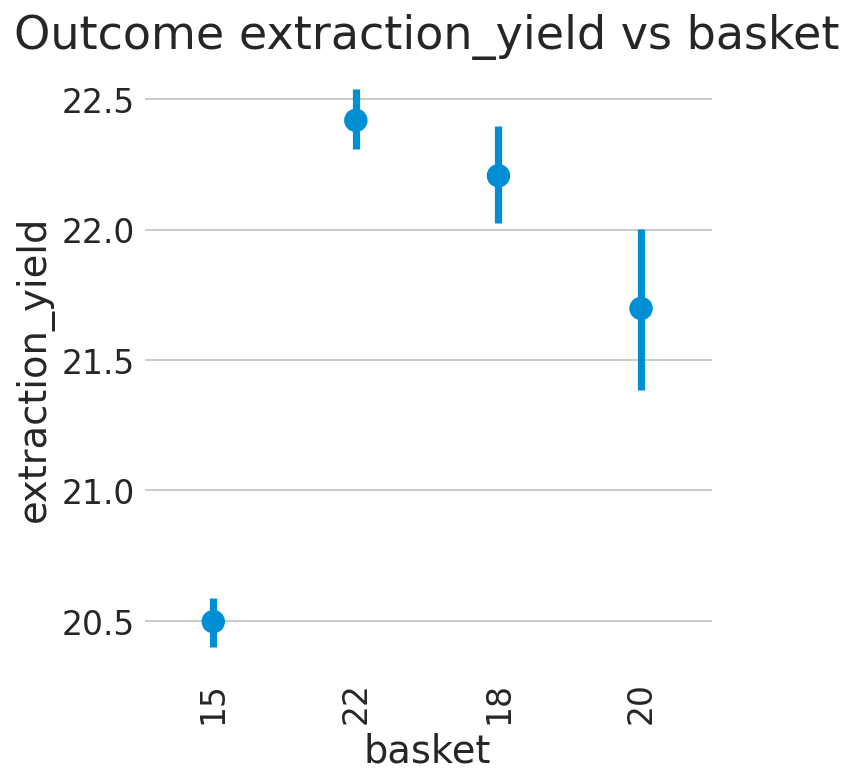

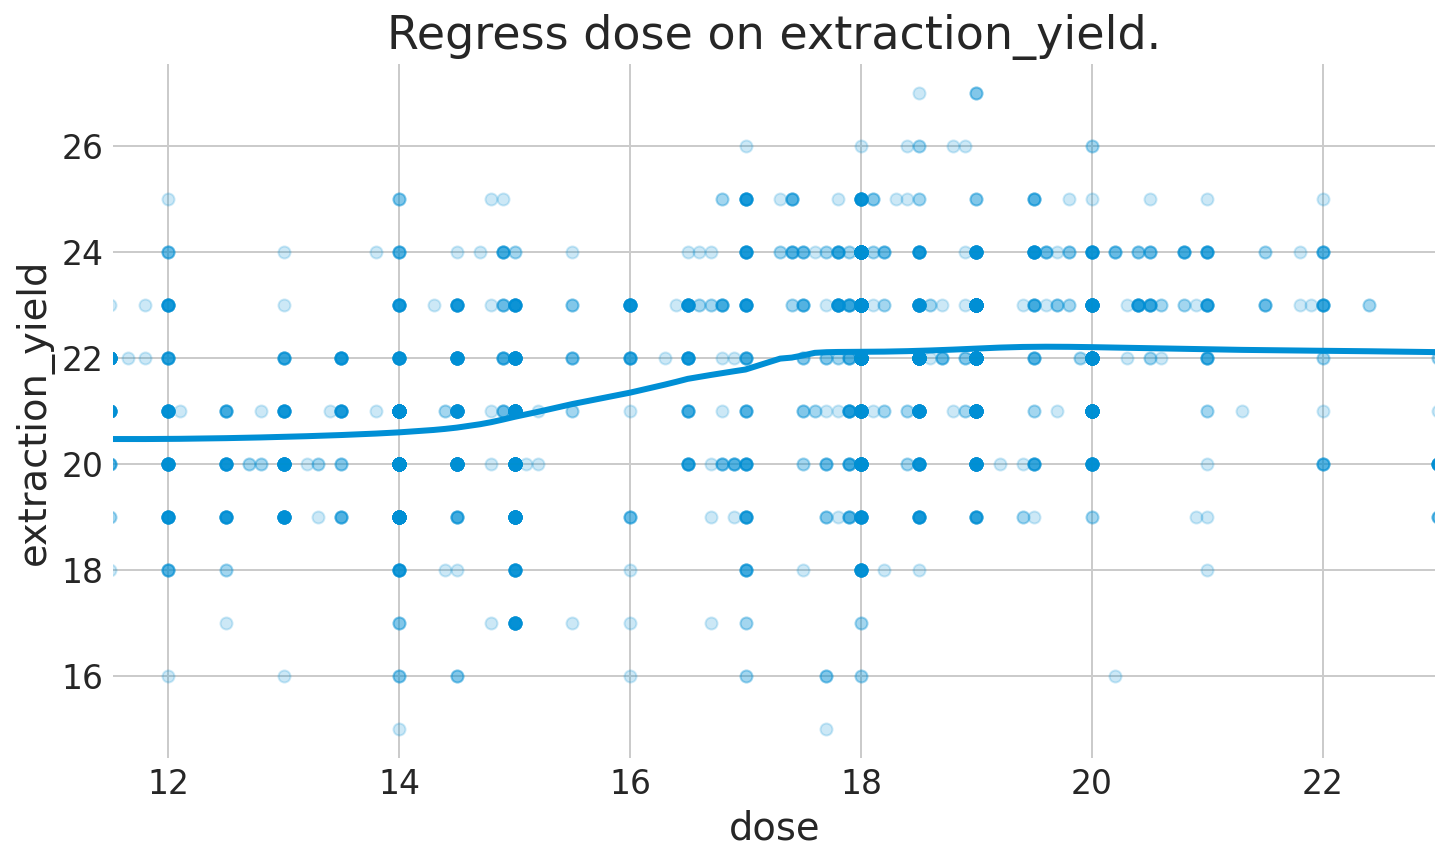

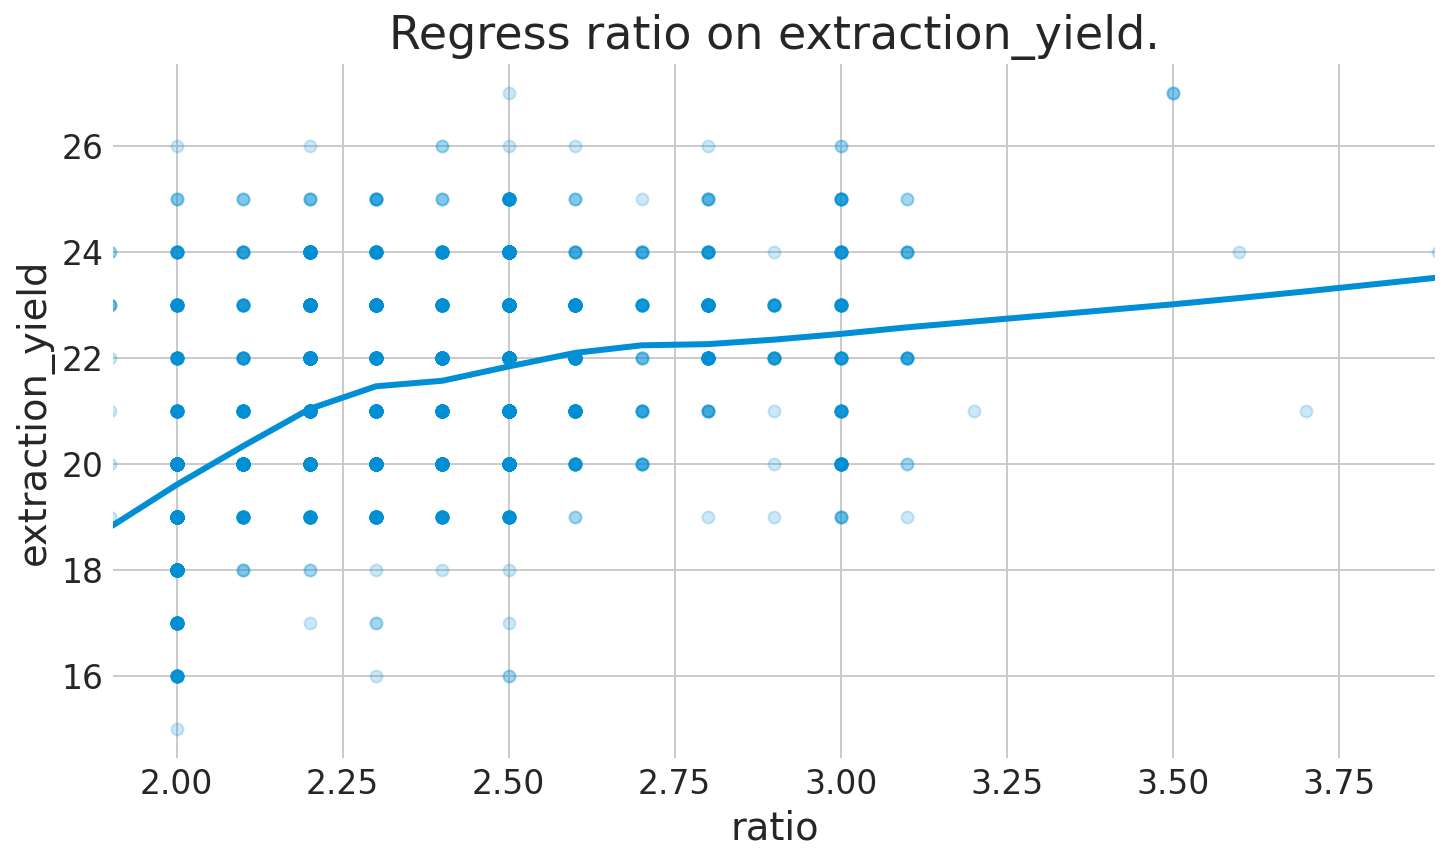

<Figure size 864x576 with 0 Axes>

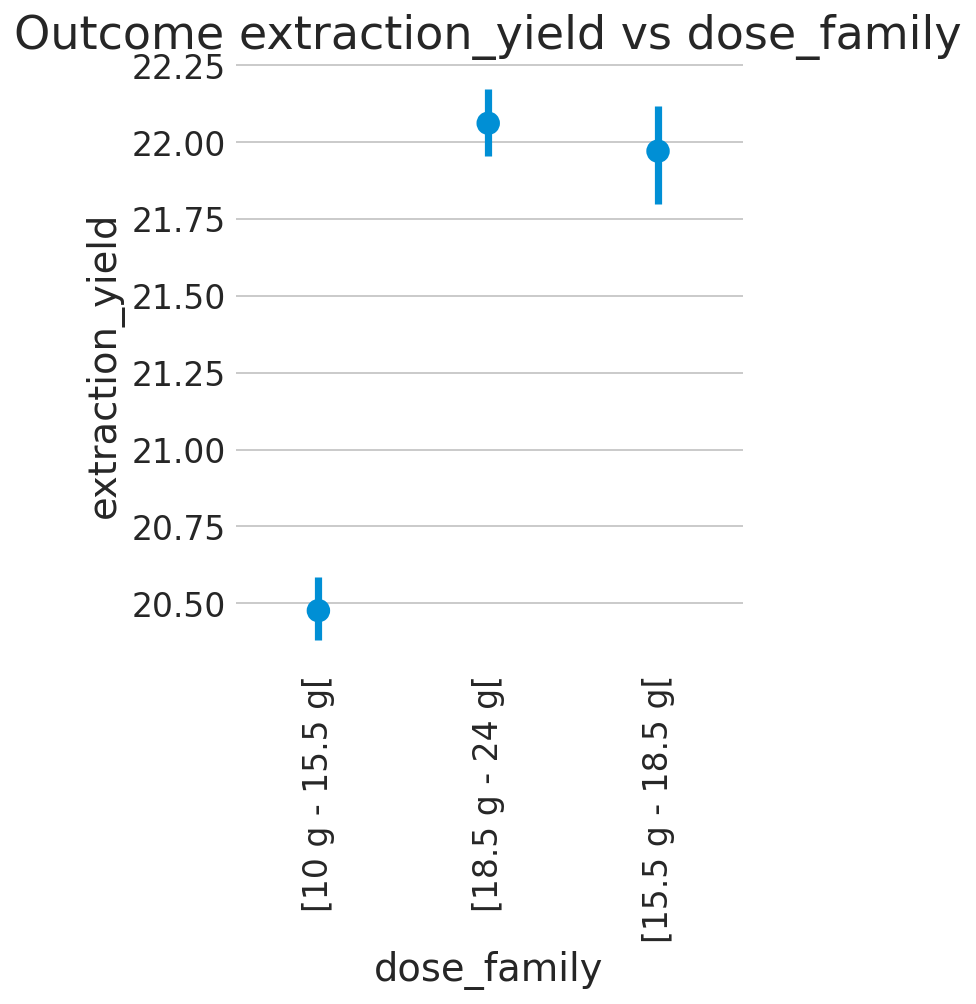

<Figure size 864x576 with 0 Axes>

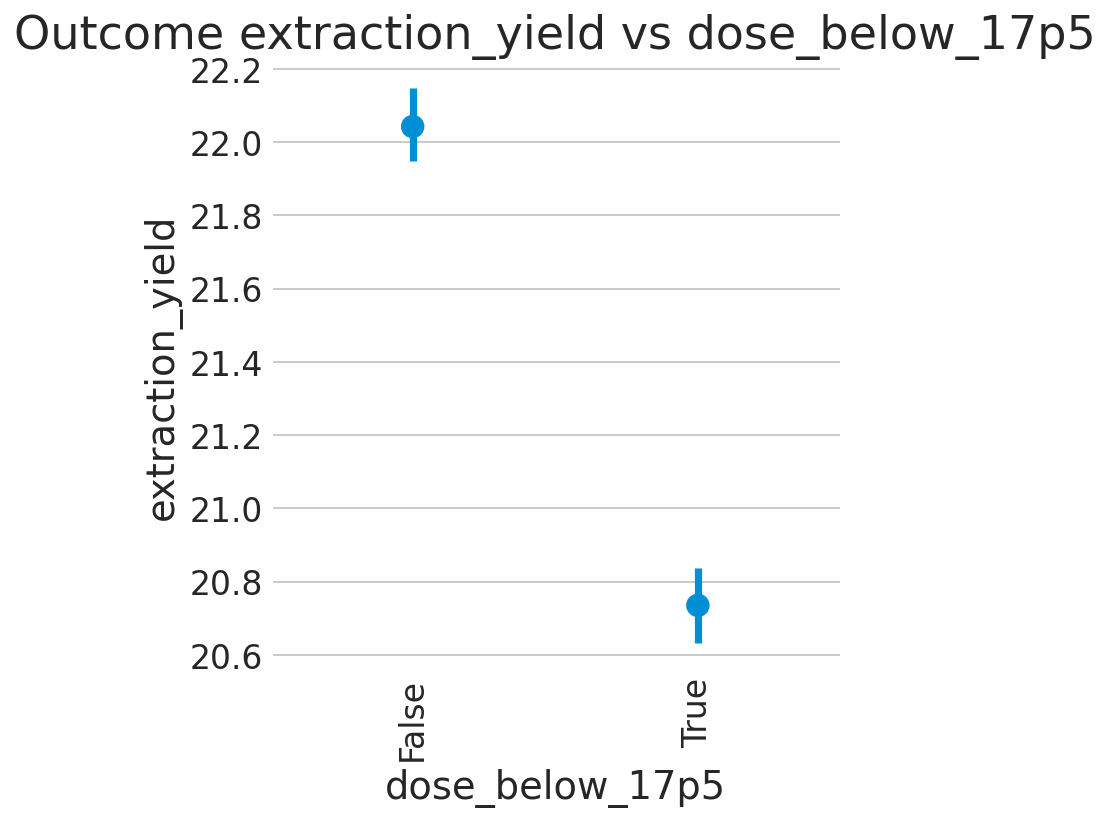

<Figure size 864x576 with 0 Axes>

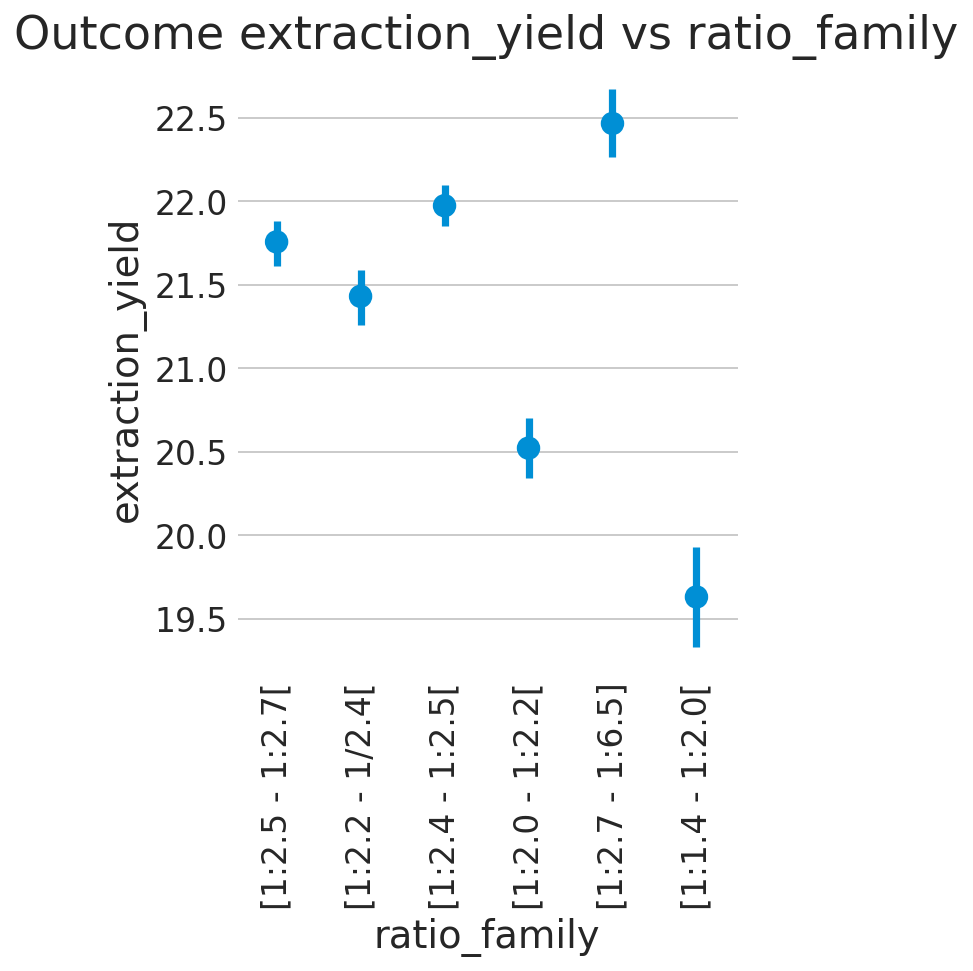

<Figure size 864x576 with 0 Axes>

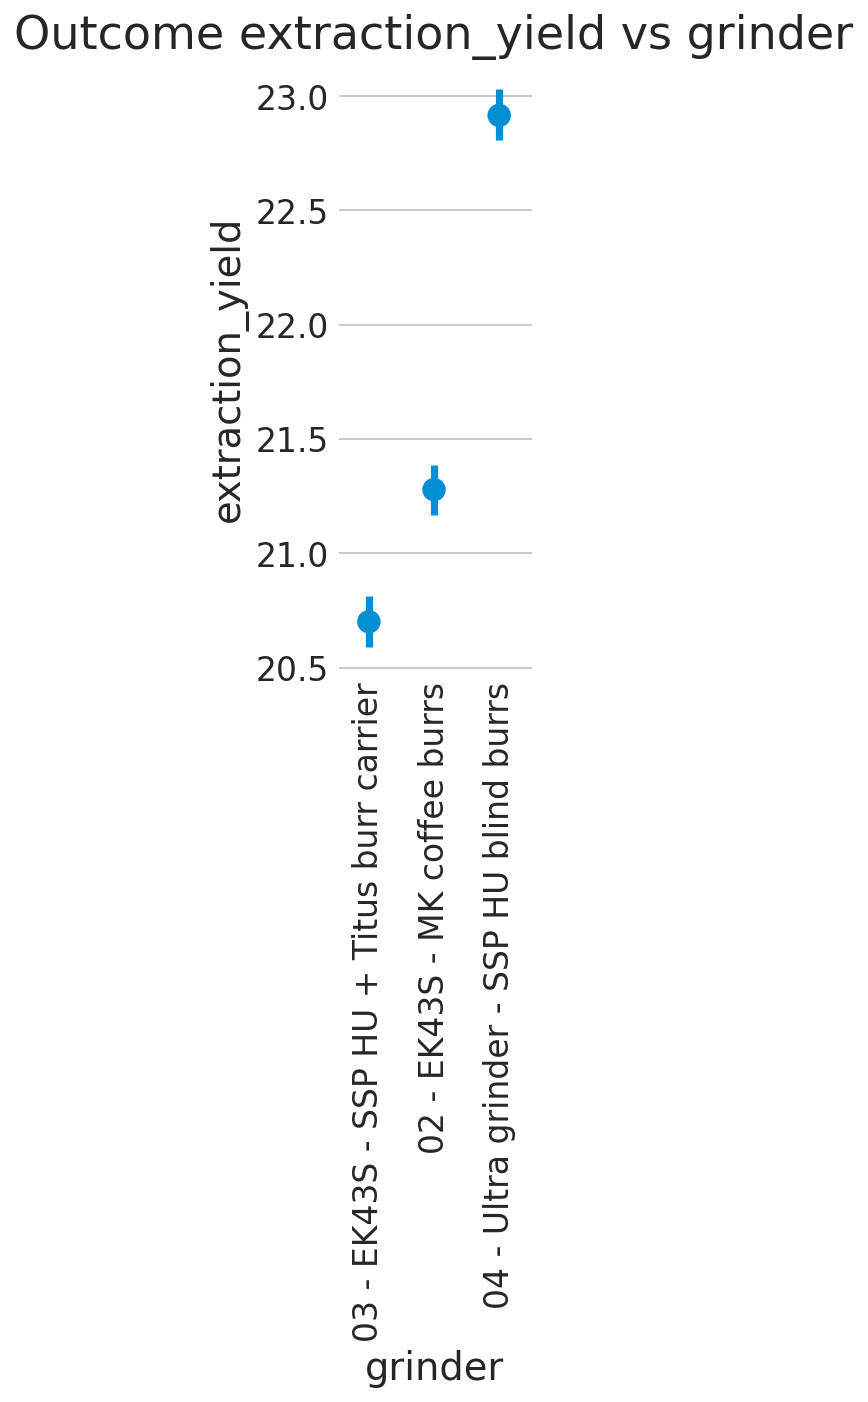

<Figure size 864x576 with 0 Axes>

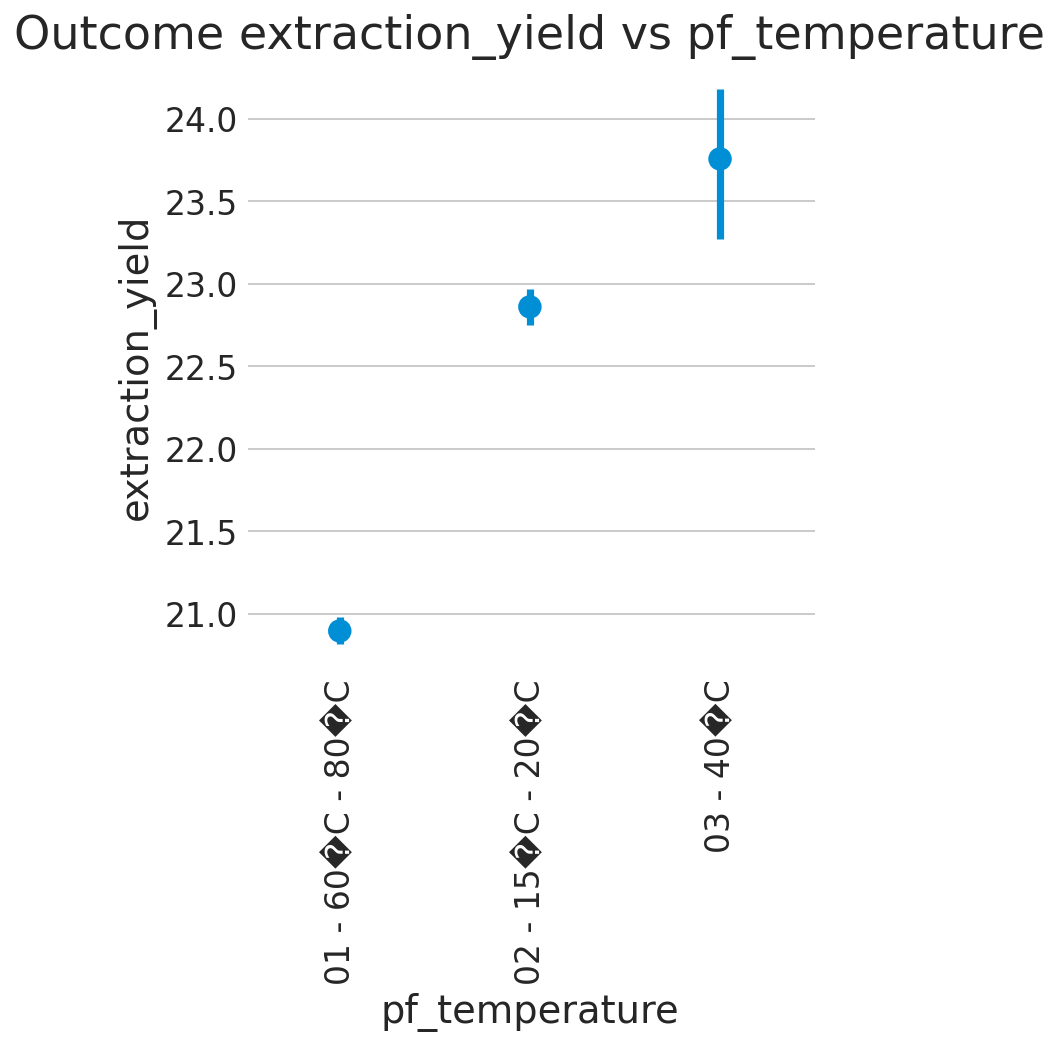

<Figure size 864x576 with 0 Axes>

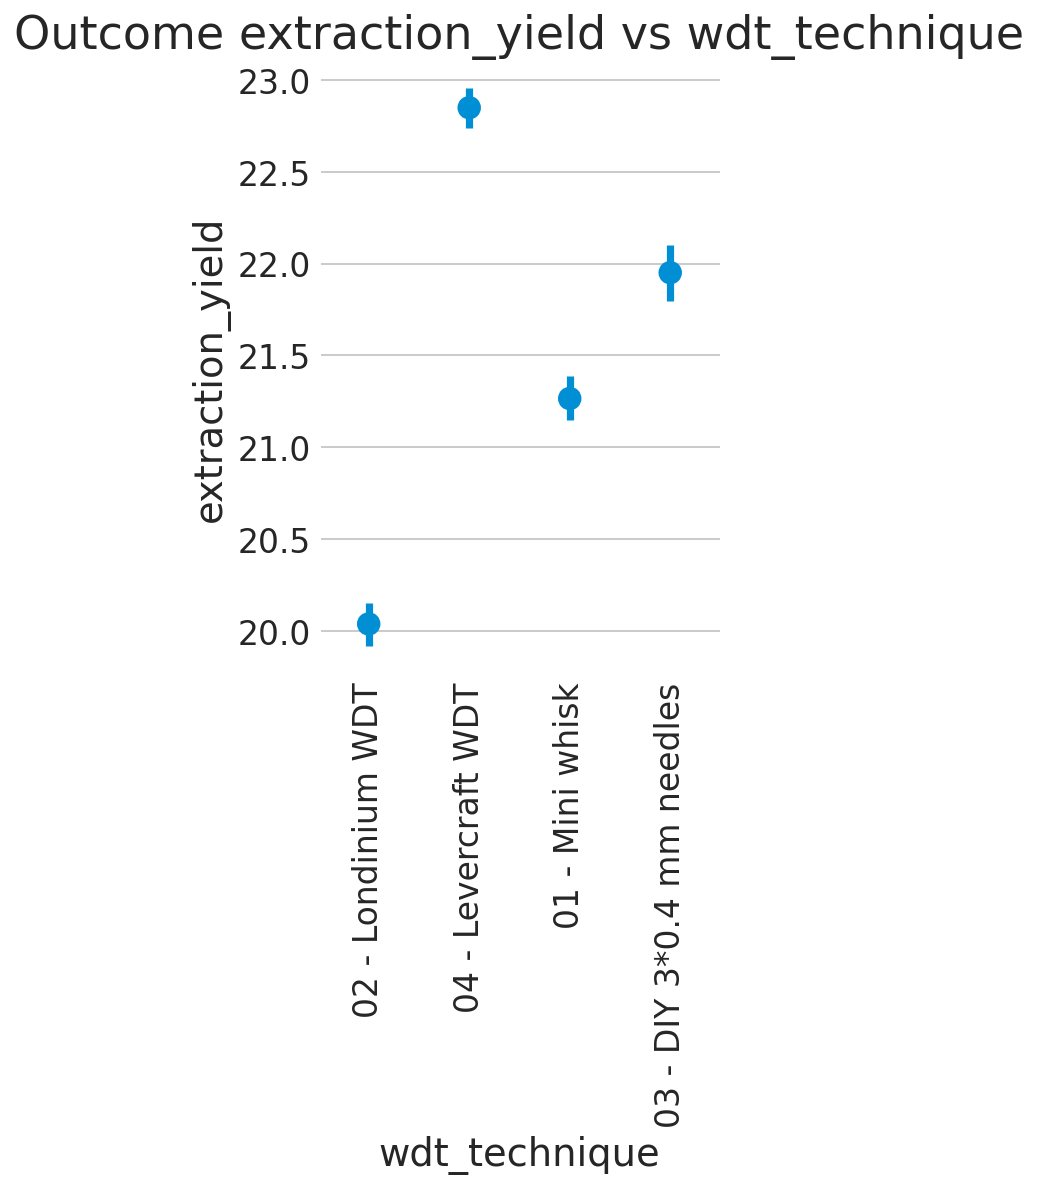

<Figure size 864x576 with 0 Axes>

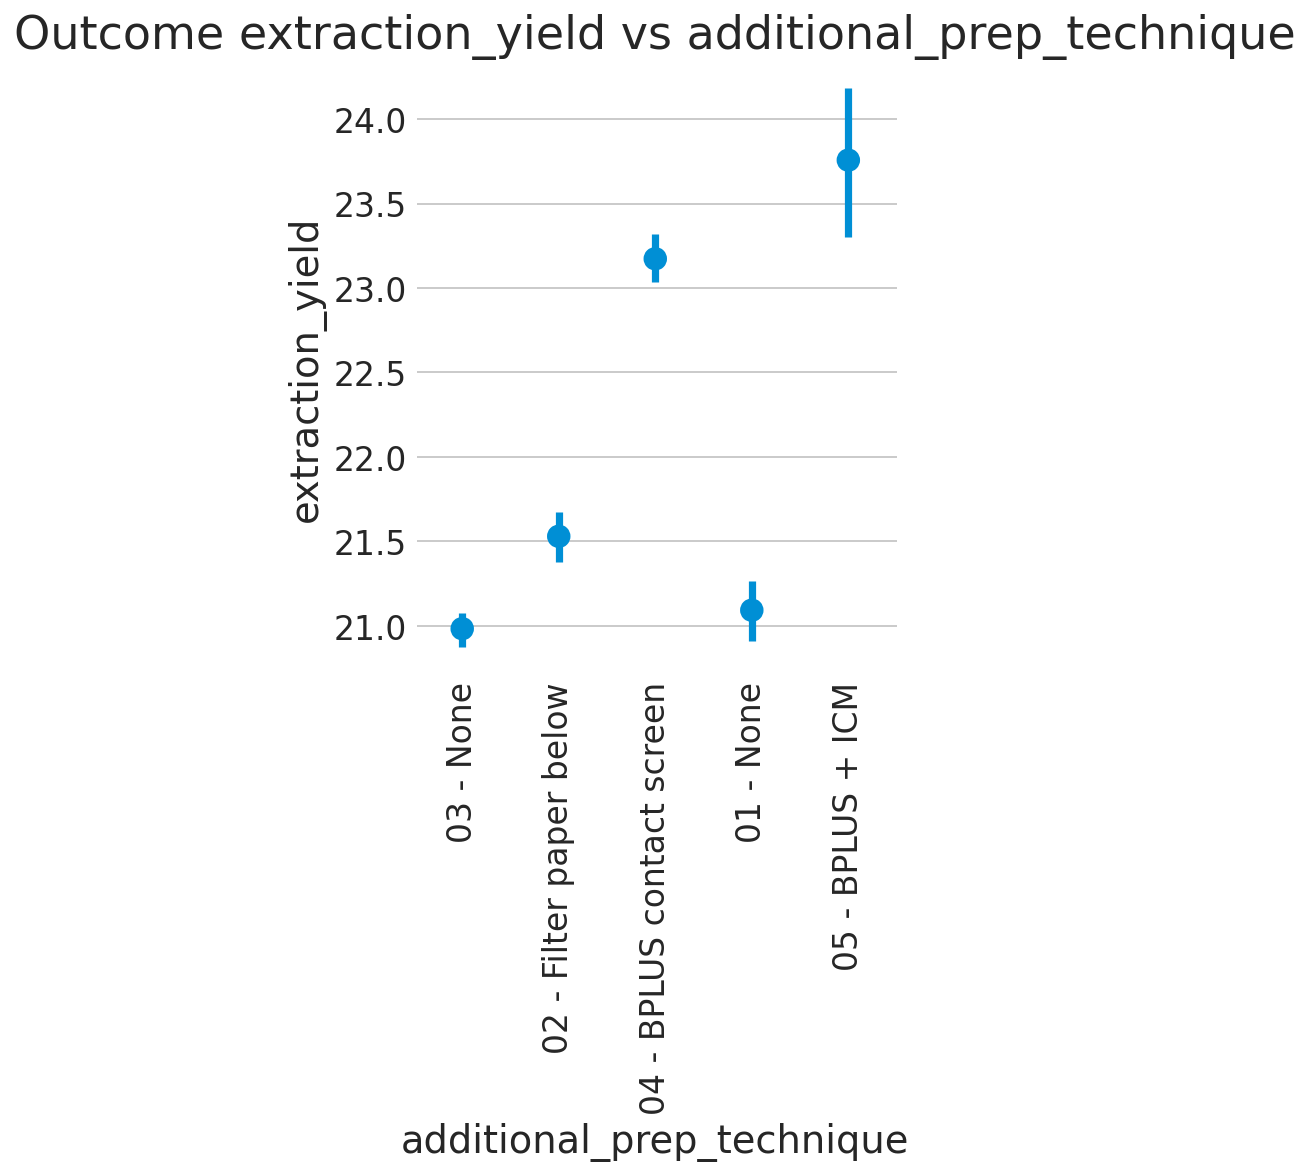

<Figure size 864x576 with 0 Axes>

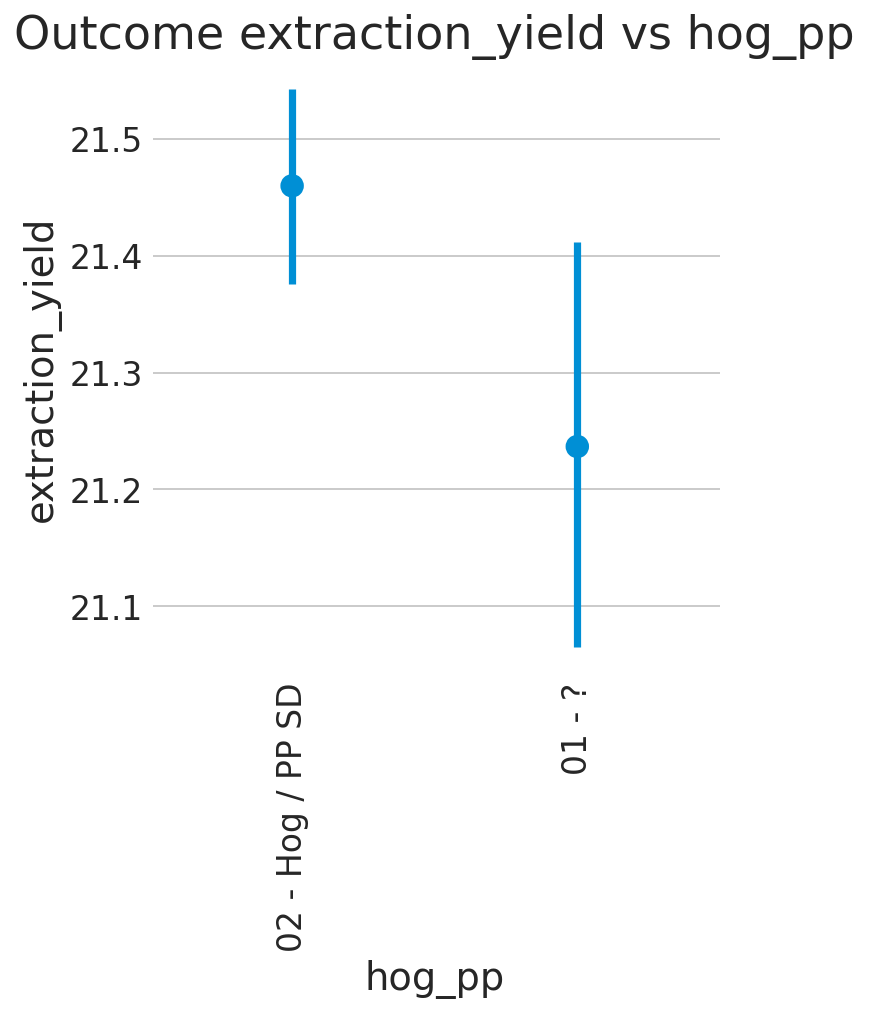

<Figure size 864x576 with 0 Axes>

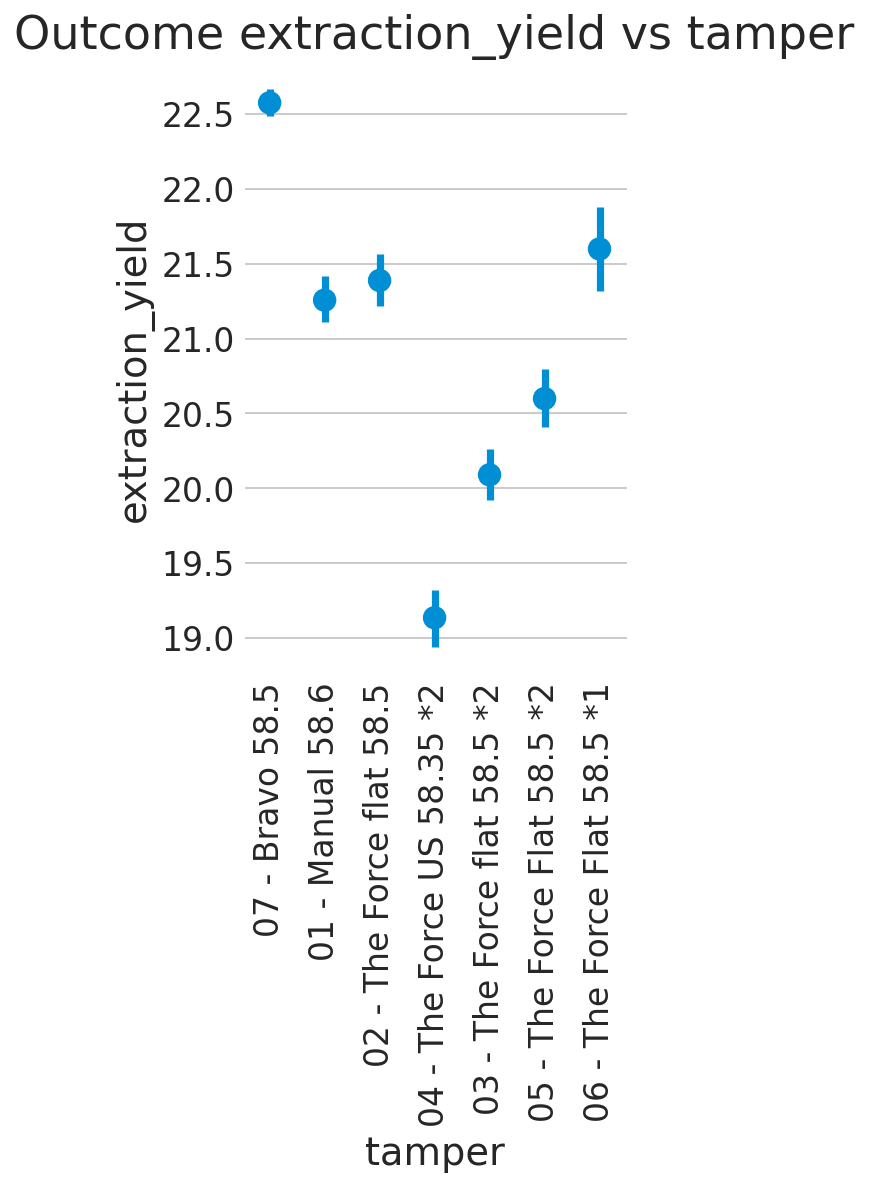

<Figure size 864x576 with 0 Axes>

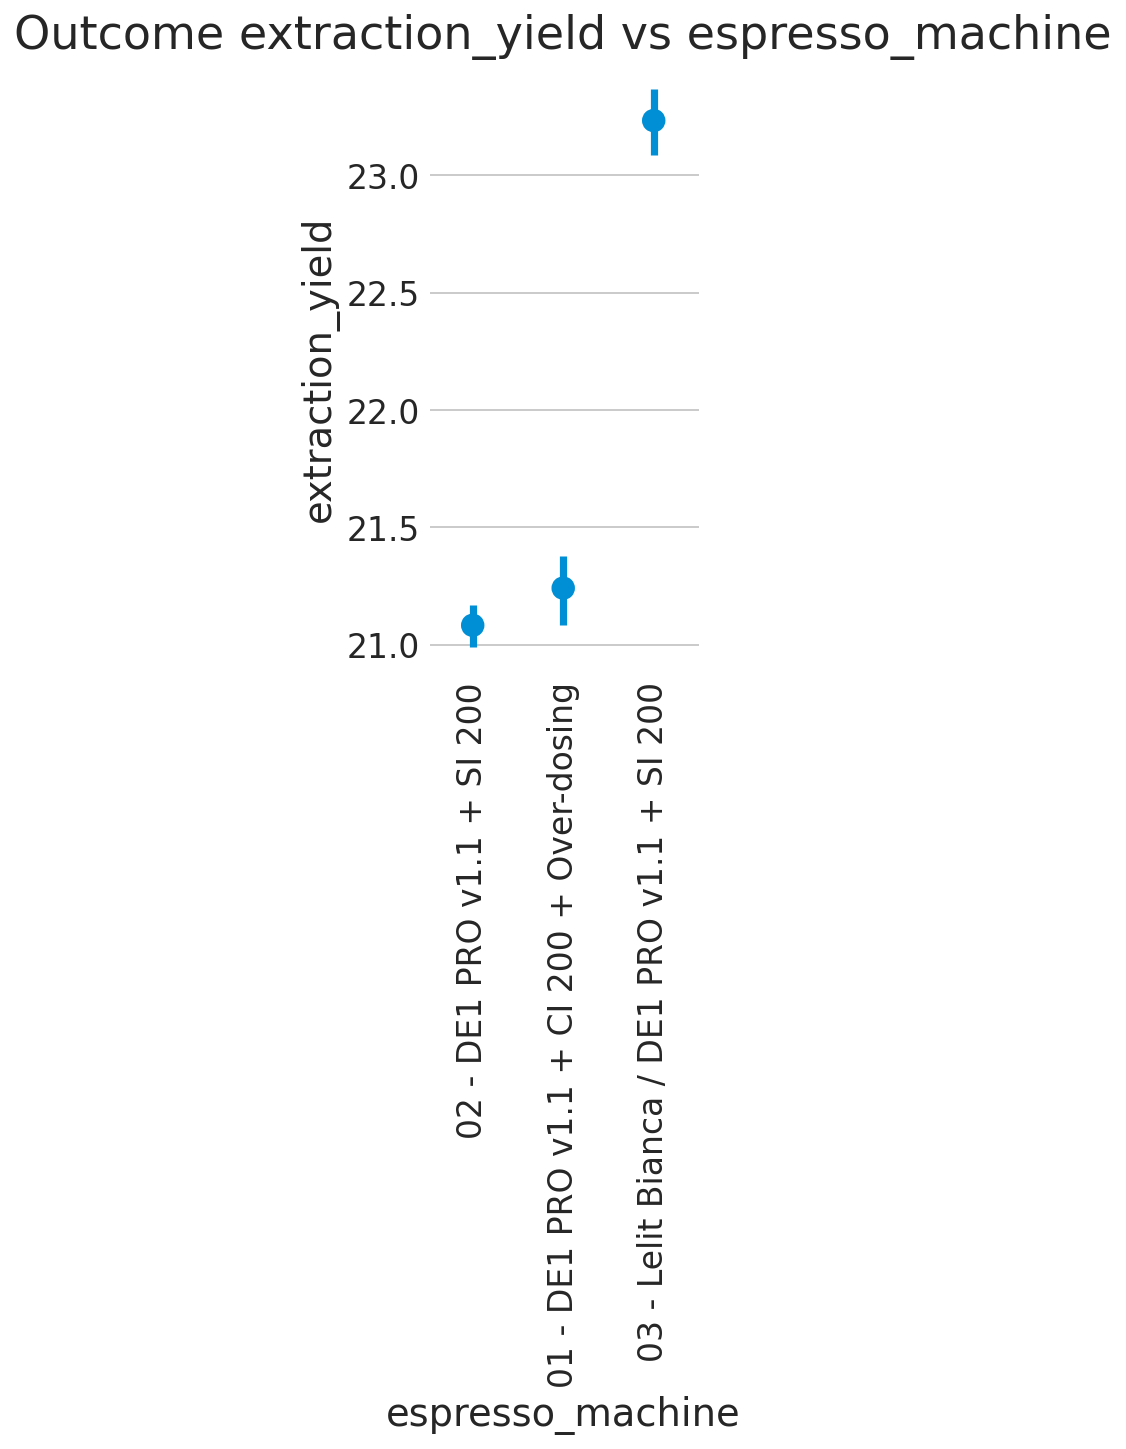

<Figure size 864x576 with 0 Axes>

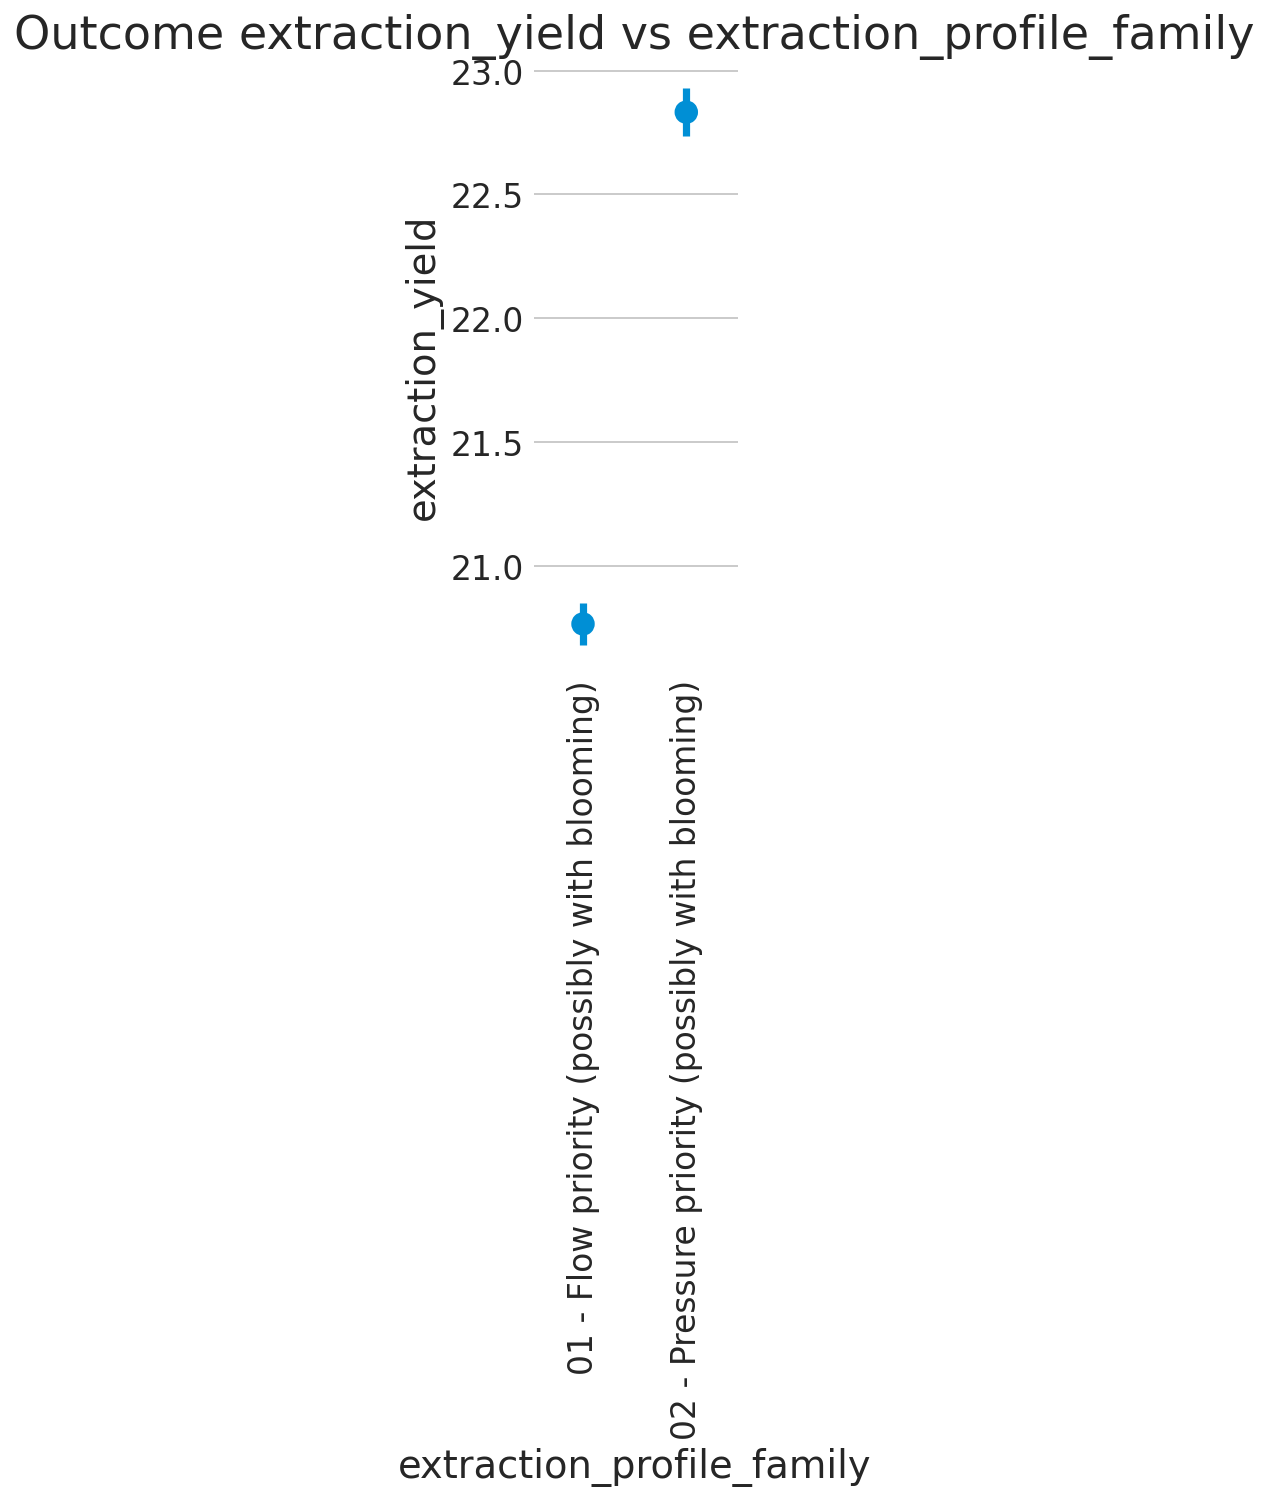

<Figure size 864x576 with 0 Axes>

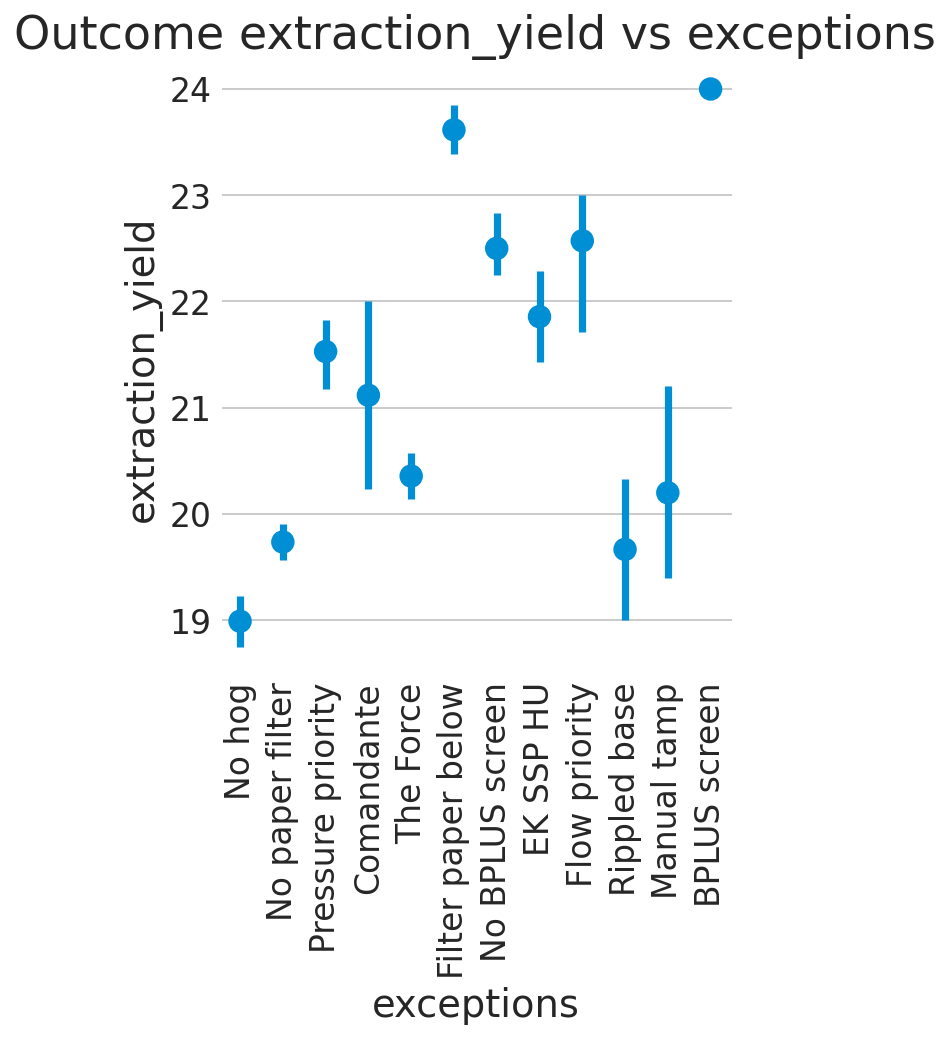

<Figure size 864x576 with 0 Axes>

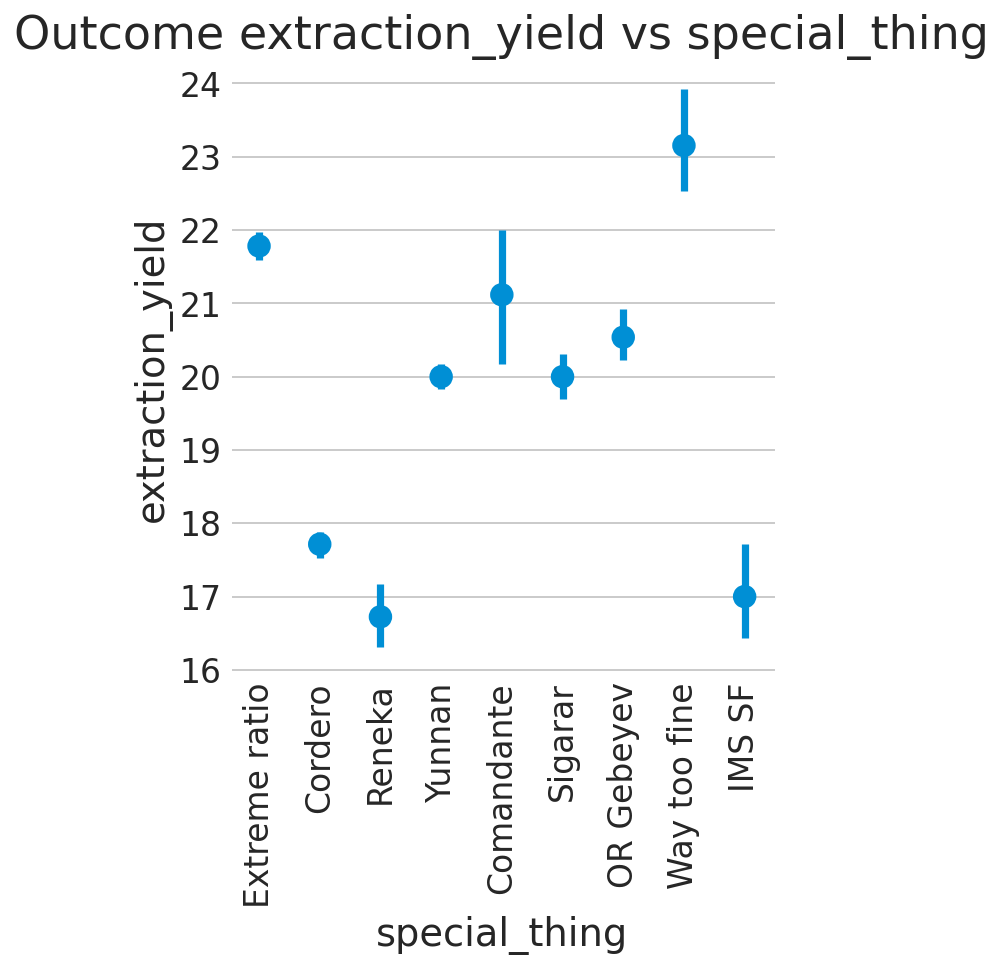

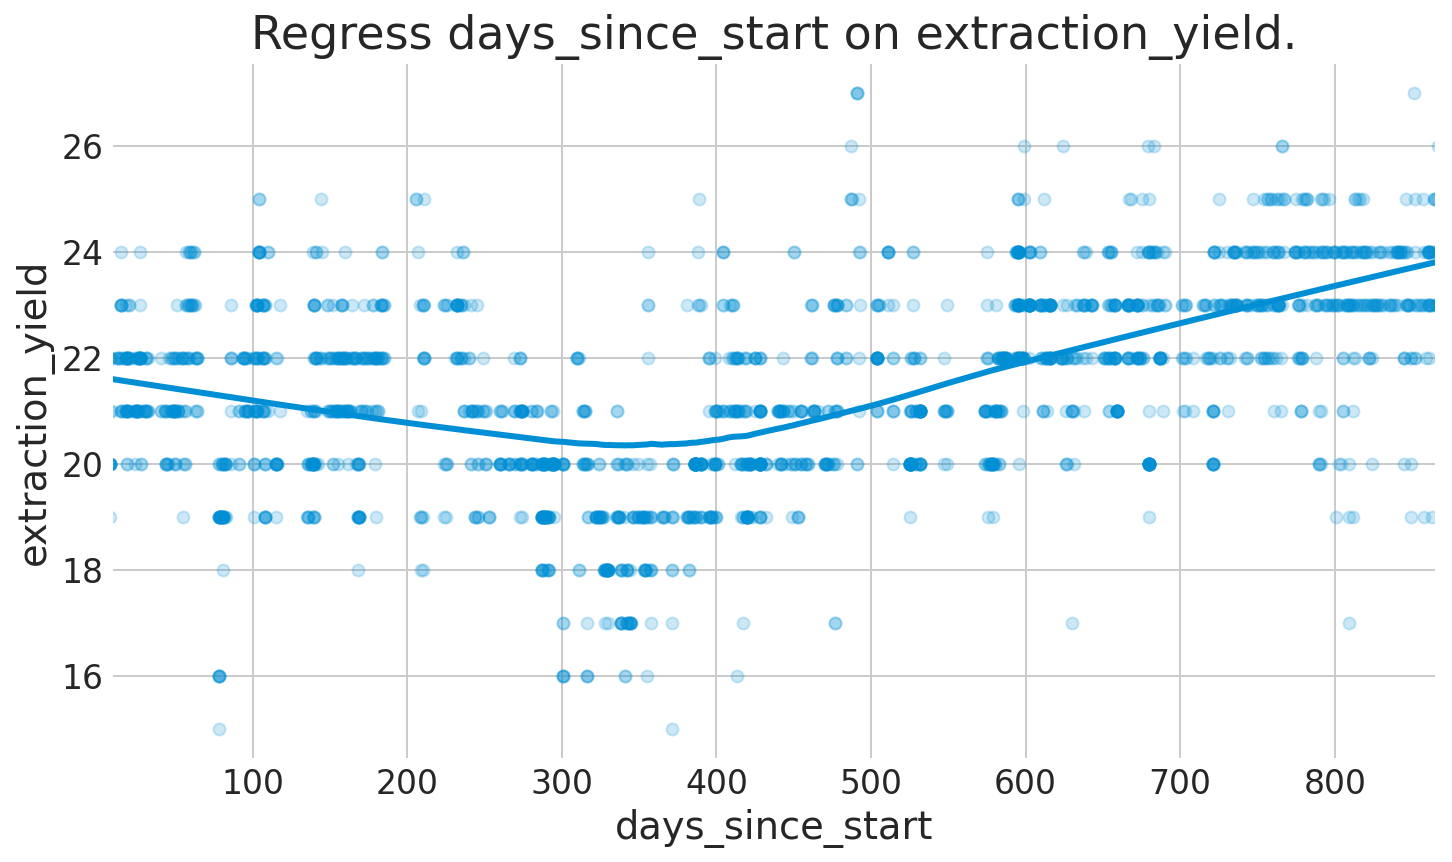

In [116]:
FEATS = [
    "basket",
    "dose",
    "ratio",
    "dose_family",
    "dose_below_17p5",
    "ratio_family",
    "grinder",
    "pf_temperature",
    "wdt_technique",
    "additional_prep_technique",
    "hog_pp",
    "tamper",
    "espresso_machine",
    "extraction_profile_family",
    "exceptions",
    "special_thing",
    "days_since_start",
]

plot_univariate(
    spros,
    FEATS,
    'extraction_yield',
)

__univariate plot thots__

- higher extractions with larger baskets and doses - mostly (18 > 20 but 15 really poor) (anecdotally I've had trouble getting 15 VST to perform well, so this seems _sane_)
- basket effect looks like 15- --> low EY and 18+ --> high EY; but no real effect going >18 or likewise below 14 (in other words, past a certain point we achieve puck integrity?)
- diminishing returns on ratio past 2.5 ish - makes sense! of course we'd expect rapidly worse EY below 1:2 (stephane wisely doesn't pull shots below 1:2 ;) )
- surprisingly large effects of basket temp? not sure of the context here, confounds, etc.  
- pretty large wdt effects, again confounds with time etc.
- filter paper + bplus + icm seem to help EY a bit (shown in experiments so observational isn't particularly interesting)
- marginal effect of hog/pp
- wary of looking into tamper diffs due to time confound  
- didn't really dig into exceptions/special but mostly make sense.  


Text(0.5, 1.0, 'verify outcome normal-ish')

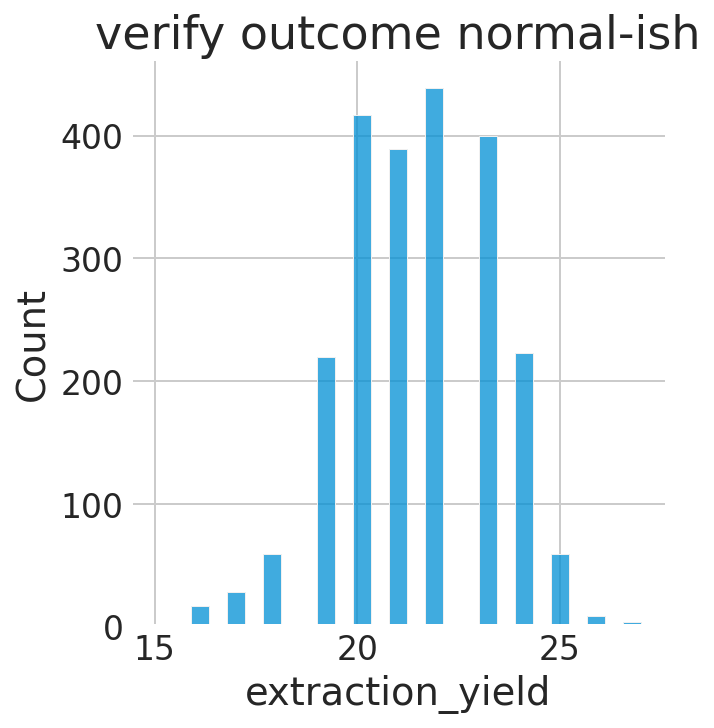

Text(0.5, 1.0, 'verify outcome normal-ish')

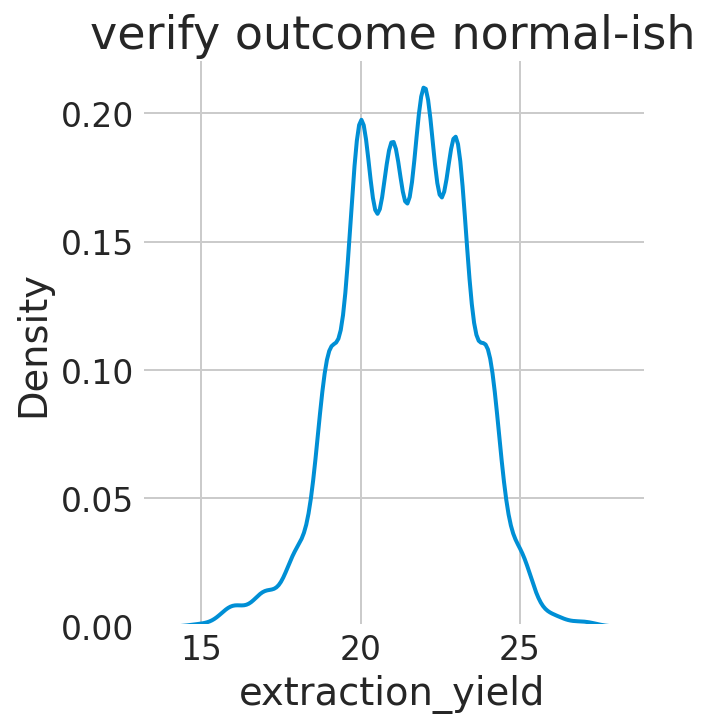

In [180]:
# outcome normality

sns.displot(spros.extraction_yield, kind='hist')
plt.title('verify outcome normal-ish')
plt.show()

sns.displot(spros.extraction_yield, kind='kde')
plt.title('verify outcome normal-ish')
plt.show()

### Time confound

<AxesSubplot:xlabel='days_since_start', ylabel='dose'>

Text(0.5, 1.0, 'dose confounded w/ days since start')

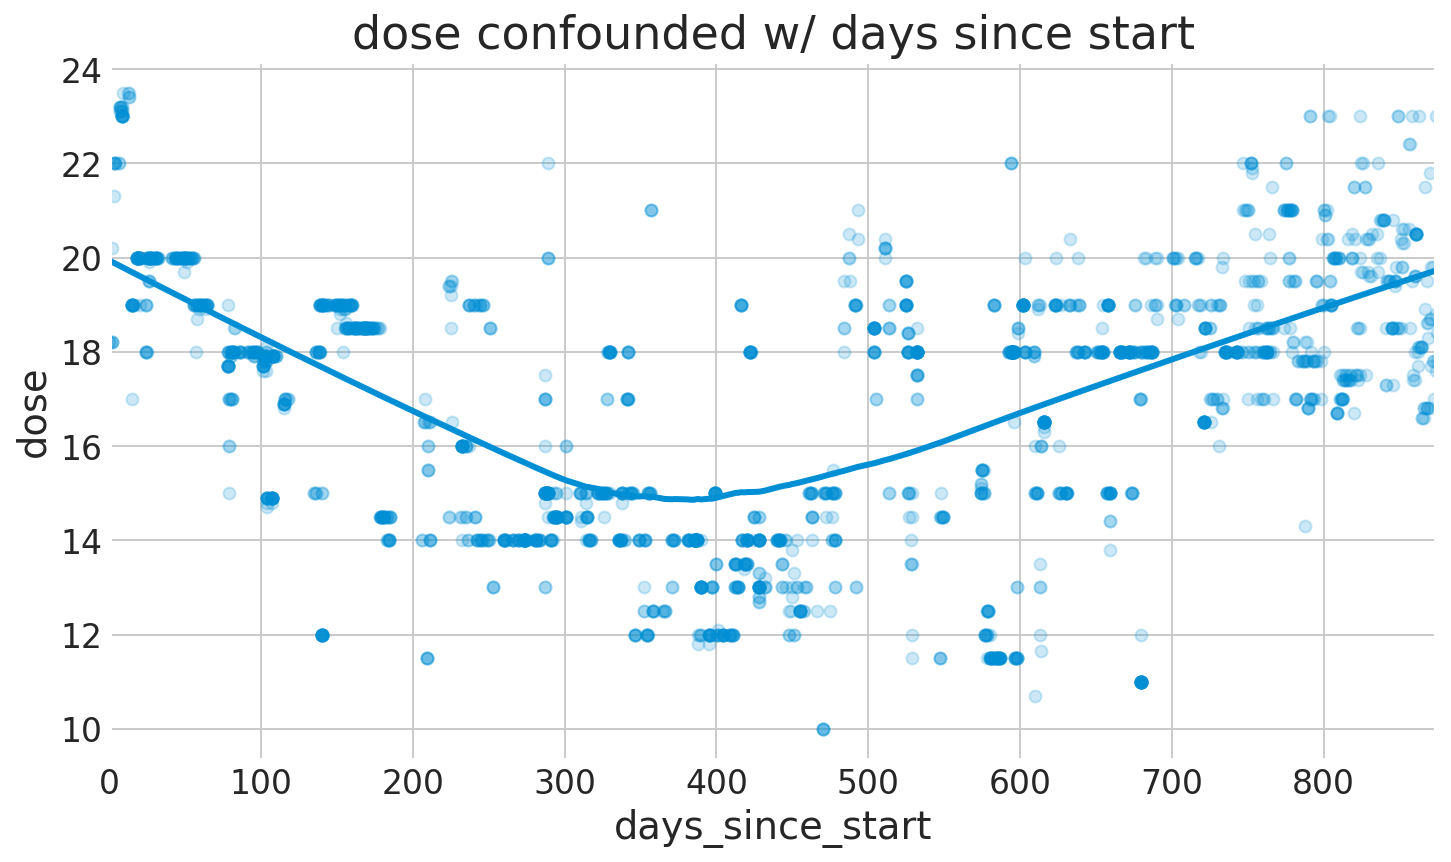

<AxesSubplot:xlabel='days_since_start', ylabel='ratio'>

Text(0.5, 1.0, 'ratio confounded w/ days since start')

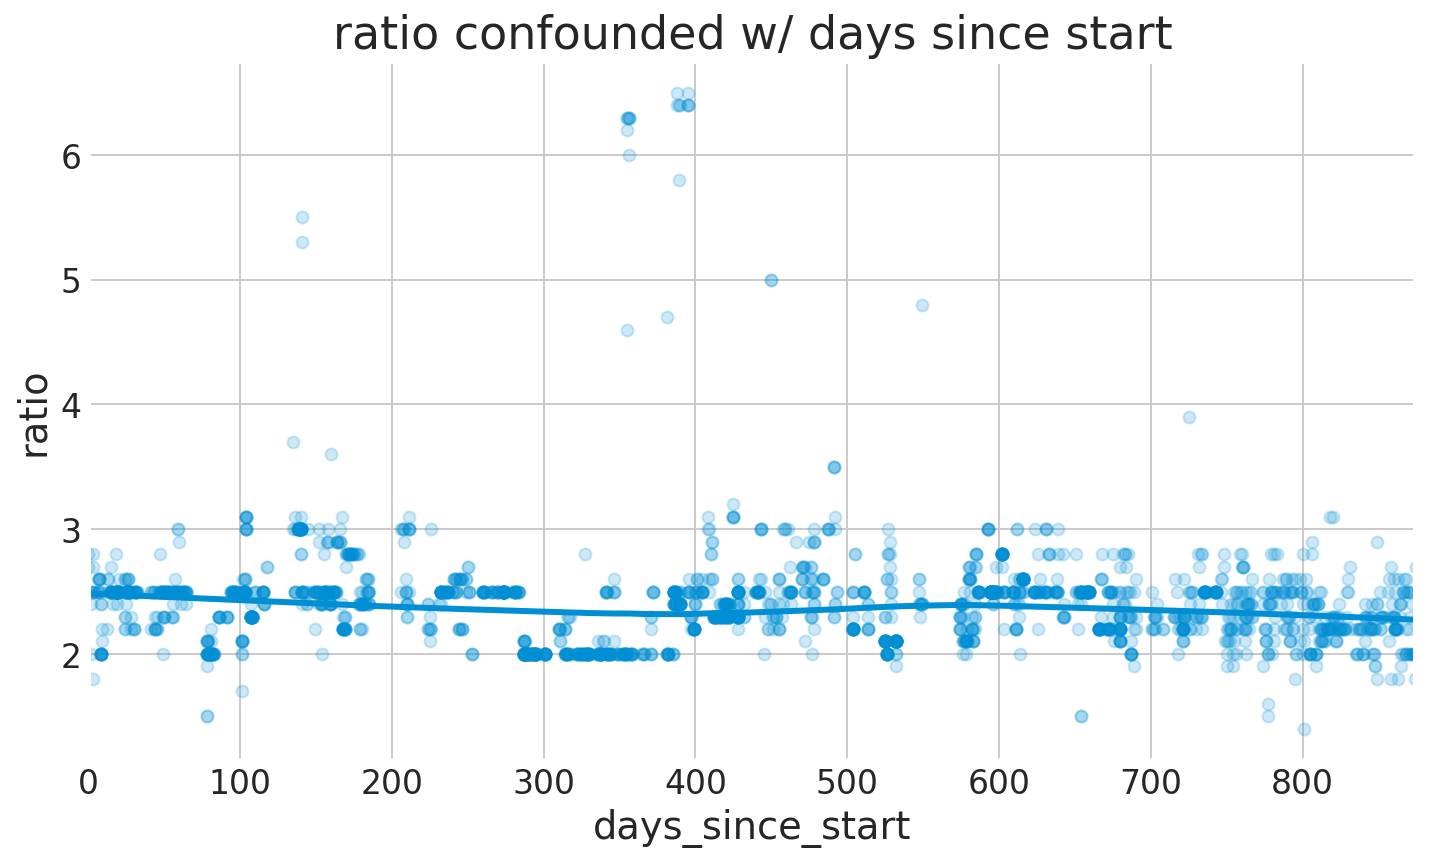

In [181]:
for feat in ['dose', 'ratio']:
    sns.regplot(
        x='days_since_start',
        y=feat,
        data=spros,
        lowess=True,
        scatter_kws={'alpha':.2},
    )
    plt.title(f"{feat} confounded w/ days since start")
    plt.show()
    


#### dose?

Text(0.5, 0.98, 'EY~Baskets*Dose (excl. exceptions/special)')

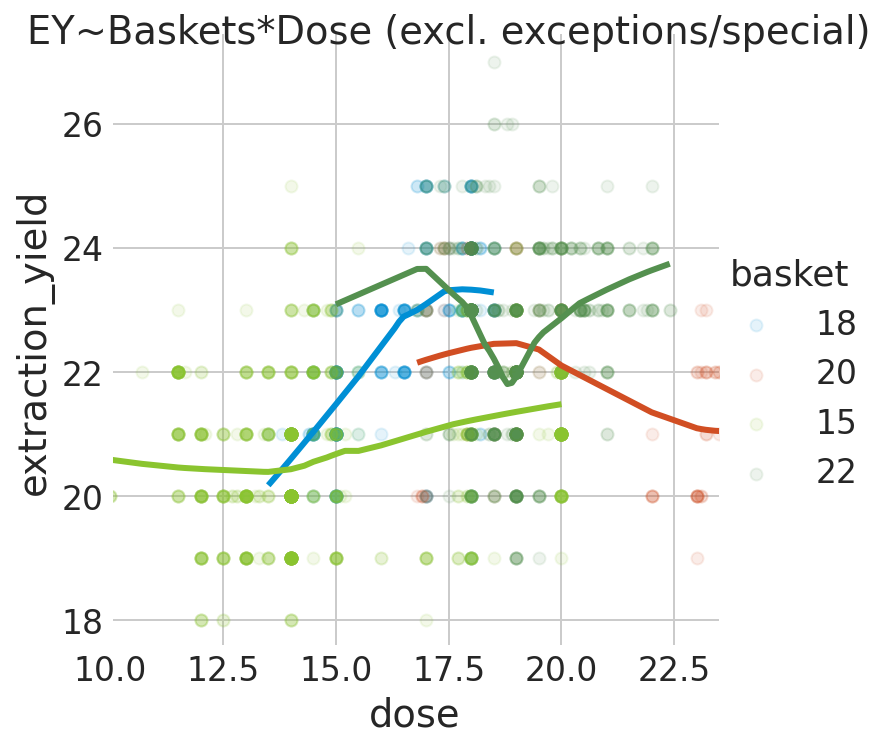

Text(0.5, 0.98, 'EY~Baskets*Dose (excl. exceptions/special)')

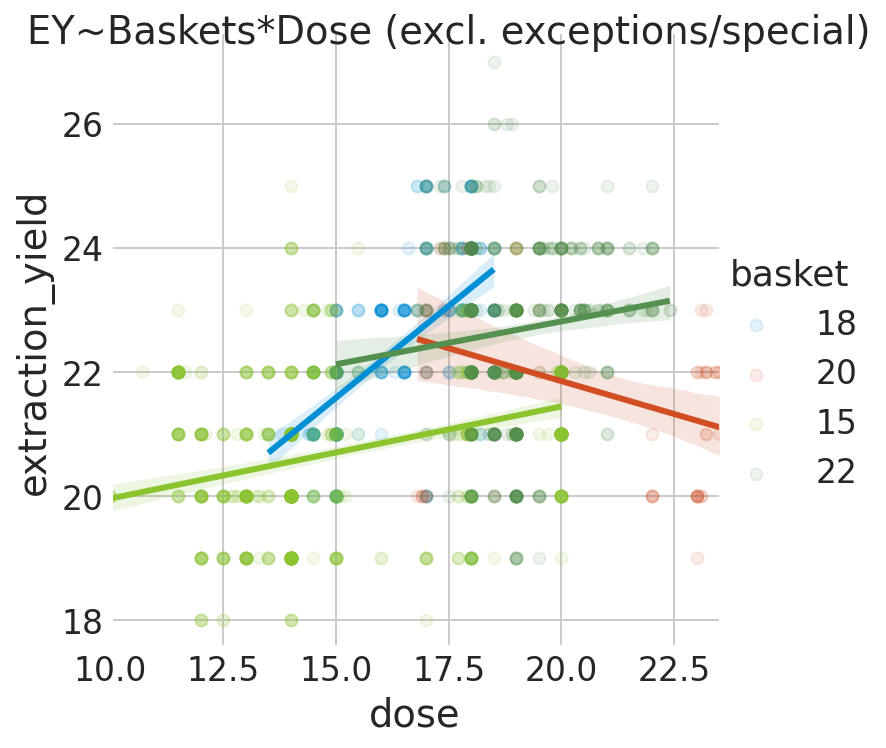

In [182]:
# dig into basket / dose (1)
sns.lmplot(
    x='dose',
    y='extraction_yield',
    hue='basket',
    data=spros.loc[spros[['exceptions', 'special_thing']].isna().all(axis='columns')],
    lowess=True,
    scatter_kws={'alpha':.1},
)
plt.suptitle(f"EY~Baskets*Dose (excl. exceptions/special)")
#plt.tight_layout()
plt.savefig('../figures/dose_mixed_model_lowess.png')
plt.show()

# dig into basket / dose (2)
sns.lmplot(
    x='dose',
    y='extraction_yield',
    hue='basket',
    data=spros.loc[spros[['exceptions', 'special_thing']].isna().all(axis='columns')],
    robust=True,
    scatter_kws={'alpha':.1},
)
plt.suptitle(f"EY~Baskets*Dose (excl. exceptions/special)")
#plt.tight_layout()
plt.savefig('../figures/dose_mixed_model_robust.png')
plt.show()

Text(0.5, 0.98, 'dose x ratio confound?')

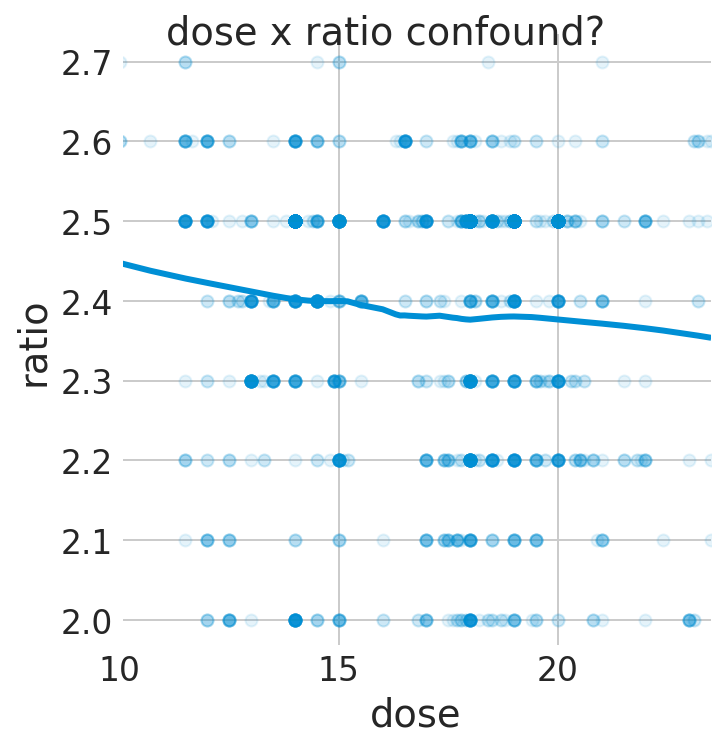

In [184]:
# ratio confound?
sns.lmplot(
    x='dose',
    y='ratio',
    #hue='basket',
    data=spros.loc[spros[['exceptions', 'special_thing']].isna().all(axis='columns')],
    lowess=True,
    scatter_kws={'alpha':.1},
)
plt.suptitle(f"dose x ratio confound?")
#plt.tight_layout()
plt.savefig('../figures/dose_ratio.png')
plt.show()

__digging in on dose__

- within the 15 basket, uniformly pretty poor extractions  
- 18 seems to get better until 18-ish g, but stephane didn't try over-dosing it  
- 20 seems pretty stable to slightly higher EY at higher dose  
- 22 doesn't have much data and variance in dose so hard to say much.  
- arguably the 18 and 20 extract highest.  
- presumably, stephane was getting better at puck prep, but due to declining doses, his EY _decreased_ early on?  
- I'm genuinely a bit confused, would be very cool to run some experiments here.   

### LM

In [117]:
# Full model, stick everything in (circular, confounded, collinear, etc.)

import statsmodels.api as sm
import statsmodels.formula.api as smf


formula = f"""extraction_yield ~ {' + '.join(FEATS)}"""
formula

mod = smf.ols(
    formula=formula, 
    data=spros,
)
res = mod.fit()
res.summary()

'extraction_yield ~ basket + dose + ratio + dose_family + dose_below_17p5 + ratio_family + grinder + pf_temperature + wdt_technique + additional_prep_technique + hog_pp + tamper + espresso_machine + extraction_profile_family + exceptions + special_thing + days_since_start'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       extraction_yield   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     27.98
Date:                Sat, 26 Jun 2021   Prob (F-statistic):           5.03e-36
Time:                        19:06:46   Log-Likelihood:                -118.44
No. Observations:                 130   AIC:                             296.9
Df Residuals:                     100   BIC:                             382.9
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
================================================================================================================================================
                                                                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                       10.9218      1.854      5.890      0.000       7.243      14.601
basket[T.18]                                                                    -0.3810      0.679     -0.561      0.576      -1.729       0.966
basket[T.20]                                                                    -1.0606      0.739     -1.436      0.154      -2.526       0.405
basket[T.22]                                                                    -0.3418      0.560     -0.610      0.543      -1.453       0.770
basket[T.IMS SF]                                                             -1.659e-13   9.04e-14     -1.835      0.069   -3.45e-13    1.34e-14
basket[T.Reneka]                                                                 0.7184      0.913      0.787      0.433      -1.093       2.530
dose_family[T.[15.5 g - 18.5 g[]                                                -0.4458      0.599     -0.744      0.458      -1.634       0.742
dose_family[T.[18.5 g - 24 g[]                                                  -0.8124      0.838     -0.970      0.335      -2.475       0.850
dose_below_17p5[T.True]                                                          0.3359      0.756      0.444      0.658      -1.163       1.835
ratio_family[T.[1:2.0 - 1:2.2[]                                                  0.7171      0.429      1.672      0.098      -0.134       1.568
ratio_family[T.[1:2.2 - 1/2.4[]                                                  1.5137      0.722      2.097      0.039       0.081       2.946
ratio_family[T.[1:2.4 - 1:2.5[]                                                  2.4014      0.955      2.515      0.013       0.507       4.296
ratio_family[T.[1:2.5 - 1:2.7[]                                                  0.1792      1.101      0.163      0.871      -2.004       2.363
ratio_family[T.[1:2.7 - 1:6.5]]                                                  1.5272      1.699      0.899      0.371      -1.844       4.898
grinder[T.03 - EK43S - SSP HU + Titus burr carrier]                             -0.9402      0.854     -1.101      0.273      -2.634       0.753
grinder[T.04 - Ultra grinder - SSP HU blind burrs]                              -0.8258      0.806     -1.024      0.308      -2.426       0.774
pf_temperature[T.02 - 15�C - 20�C]                                              -0.8258      0.806     -1.024      0.308      -2.426       0.774
pf_temperature[T.03 - 40�C]                                                   3.453e-16   5.45e-15      0.063      0.950   -1.05e-14    1.12e-14
wdt_technique[T.02 - Londinium WDT]   

I'm going to refrain from trying to interpret these initial models due to multicollinearity.

In [118]:
# add some regularization to drop out rare cats etc.

mod = smf.ols(
    formula=formula, 
    data=spros,
)
res = mod.fit_regularized(
    method='elastic_net',
    alpha=1e-7,  # all L1, add some to simplify
    L1_wt=1.0,
    refit=True,
)
res.summary()

/home/jan/miniconda3/envs/2021-03/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       extraction_yield   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     16.42
Date:                Sat, 26 Jun 2021   Prob (F-statistic):           5.02e-27
Time:                        19:07:24   Log-Likelihood:                -118.44
No. Observations:                 130   AIC:                             324.9
Df Residuals:                      87   BIC:                             451.1
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
================================================================================================================================================
                                                                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                       10.9604      1.975      5.549      0.000       7.035      14.886
basket[T.18]                                                                    -0.4004      0.734     -0.546      0.587      -1.858       1.058
basket[T.20]                                                                    -1.1435      0.871     -1.312      0.193      -2.876       0.588
basket[T.22]                                                                    -0.3418      0.601     -0.569      0.571      -1.536       0.852
basket[T.IMS SF]                                                                      0          0        nan        nan           0           0
basket[T.Reneka]                                                                 0.7184      0.979      0.734      0.465      -1.227       2.664
dose_family[T.[15.5 g - 18.5 g[]                                                -0.4458      0.642     -0.694      0.489      -1.722       0.830
dose_family[T.[18.5 g - 24 g[]                                                  -0.8124      0.898     -0.905      0.368      -2.598       0.973
dose_below_17p5[T.True]                                                          0.3359      0.810      0.415      0.680      -1.275       1.946
ratio_family[T.[1:2.0 - 1:2.2[]                                                  0.7171      0.460      1.560      0.122      -0.197       1.631
ratio_family[T.[1:2.2 - 1/2.4[]                                                  1.5137      0.774      1.956      0.054      -0.025       3.052
ratio_family[T.[1:2.4 - 1:2.5[]                                                  2.4014      1.024      2.346      0.021       0.367       4.436
ratio_family[T.[1:2.5 - 1:2.7[]                                                  0.1792      1.180      0.152      0.880      -2.166       2.524
ratio_family[T.[1:2.7 - 1:6.5]]                                                  1.5272      1.822      0.838      0.404      -2.094       5.148
grinder[T.03 - EK43S - SSP HU + Titus burr carrier]                             -0.5993      0.601     -0.998      0.321      -1.793       0.595
grinder[T.04 - Ultra grinder - SSP HU blind burrs]                              -1.4570      1.525     -0.955      0.342      -4.489       1.575
pf_temperature[T.02 - 15�C - 20�C]                                                    0          0        nan        nan           0           0
pf_temperature[T.03 - 40�C]                                                           0          0        nan        nan           0           0
wdt_technique[T.02 - Londinium WDT]   

In [91]:
spros['exceptions'].value_counts()
spros['special_thing'].value_counts()

No hog                107
No paper filter        72
Pressure priority      17
Comandante             17
The Force              14
Filter paper below     13
No BPLUS screen        12
EK SSP HU               7
Flow priority           7
Rippled base            6
Manual tamp             5
BPLUS screen            3
Paper filter below      2
EK SSP Casted           2
No ICM                  2
BPLUS + ICM             2
The Force *2            1
Name: exceptions, dtype: int64

Extreme ratio     368
Cordero            49
Reneka             29
Yunnan             18
Comandante         17
Sigarar            13
Way too fine       13
OR Gebeyev         13
IMS SF              7
Way too coarse      5
Hartman Gesha       4
Graindor            2
Name: special_thing, dtype: int64

In [151]:
# simplified - exclude a few semi-redundant categories (dose & ratio families) 
# + drop "exception" cases   
# There will be less variance to explain, so expect lower R2.
import copy


FEATS_SIMPLIFIED = copy.deepcopy(FEATS)
FEATS_RM = [
    'dose_family',    # Semi-redundant with cts form
    'ratio_family',   # ''
    'exceptions',     # Just exclude these rows so feature redundant.
    'special_thing',  # ''
    'tamper',         # Model assigns this tons of weight (2%+ EY?!)
    'basket',         # Strongly confounded with dose.
    'dose_below_17p5',# Seems like linear dose is sufficient.
    'grinder',        # Very smol effects.
    #'pf_temperature', # Small-ish effect.
    'hog_pp',
    #'espresso_machine',
    #'extraction_profile_family',
]
for feat_rm in FEATS_RM:
    FEATS_SIMPLIFIED.remove(feat_rm)

#FEATS_SIMPLIFIED

formula_simplified = f"""extraction_yield ~ {' + '.join(FEATS_SIMPLIFIED)}"""
formula_simplified

mod = smf.ols(
    formula=formula_simplified, 
    data=spros.loc[spros[['exceptions', 'special_thing']].isna().all(axis='columns')],
)
res = mod.fit_regularized(
    method='elastic_net',
    alpha=1e-9,  # all L1
    L1_wt=1.0,
    refit=True,
)
res.summary()

'extraction_yield ~ dose + ratio + pf_temperature + wdt_technique + additional_prep_technique + espresso_machine + extraction_profile_family + days_since_start'

/home/jan/miniconda3/envs/2021-03/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       extraction_yield   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     182.9
Date:                Sun, 27 Jun 2021   Prob (F-statistic):               0.00
Time:                        09:50:21   Log-Likelihood:                -2109.5
No. Observations:                1569   AIC:                             4253.
Df Residuals:                    1553   BIC:                             4344.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
================================================================================================================================================
                                                                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                       12.9803      0.451     28.791      0.000      12.096      13.865
pf_temperature[T.02 - 15�C - 20�C]                                               1.2288      0.211      5.834      0.000       0.816       1.642
pf_temperature[T.03 - 40�C]                                                      0.9156      0.311      2.941      0.003       0.305       1.526
wdt_technique[T.02 - Londinium WDT]                                              0.7676      0.172      4.465      0.000       0.430       1.105
wdt_technique[T.03 - DIY 3*0.4 mm needles]                                       1.7617      0.236      7.479      0.000       1.300       2.224
wdt_technique[T.04 - Levercraft WDT]                                             0.6740      0.331      2.035      0.042       0.024       1.324
additional_prep_technique[T.02 - Filter paper below]                             1.0866      0.161      6.729      0.000       0.770       1.403
additional_prep_technique[T.03 - None]                                          -0.9527      0.248     -3.848      0.000      -1.438      -0.467
additional_prep_technique[T.04 - BPLUS contact screen]                          -0.1240      0.541     -0.229      0.819      -1.185       0.937
additional_prep_technique[T.05 - BPLUS + ICM]                                    0.9156      0.311      2.941      0.003       0.305       1.526
espresso_machine[T.02 - DE1 PRO v1.1 + SI 200]                                  -0.8027      0.173     -4.632      0.000      -1.143      -0.463
espresso_machine[T.03 - Lelit Bianca / DE1 PRO v1.1 + SI 200]                   -1.0347      0.506     -2.046      0.041      -2.027      -0.043
extraction_profile_family[T.02 - Pressure priority (possibly with blooming)]     0.6011      0.135      4.453      0.000       0.336       0.866
dose                                                                             0.0924      0.013      6.963      0.000       0.066       0.118
ratio                                                                            2.6430      0.143     18.477      0.000       2.362       2.924
days_since_start                                                                 0.0016      0.001      2.685      0.007       0.000       0.003
==============================================================================
Omnibus:                       13.536   Durbin-Watson:                   0.987
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.636
Skew:                           0.218   Prob(JB):                      0.00109
Kurtosis:   

__lr thots__

- significant effects of lower PF temp.  
- significant effects of some WDT techniques, but hard to interpret given that there isn't much data here with _no_ wdt. so likely spurious / from other prep changes over time.  
- positive effect of filter paper, bplus+icm, middling bplus alone, worst no add'l technique (bplus or filter paper)  
- machines get assigned negative effects, presumably because stephane is improving otherwise (e.g. bplus increases EY in experiments) - think this is not a real effect  
- despite controls __still see + effect of dose (smaller)__  
- of course, positive effect of ratio.  
- positive effect of time. ("skill")    

In [137]:
# ultra simple model

mod = smf.ols(
    formula='extraction_yield ~ dose + ratio + days_since_start', 
    data=spros.loc[spros[['exceptions', 'special_thing']].isna().all(axis='columns')],
)
res = mod.fit_regularized(
    method='elastic_net',
    alpha=1e-9,  # all L1
    L1_wt=1.0,
    refit=True,
)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       extraction_yield   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     418.1
Date:                Sat, 26 Jun 2021   Prob (F-statistic):          3.88e-245
Time:                        20:09:51   Log-Likelihood:                -2370.3
No. Observations:                1569   AIC:                             4751.
Df Residuals:                    1565   BIC:                             4777.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            8.9942      0.440     20.455      0.000       8.132       9.857
dose                 0.2588      0.010     25.732      0.000       0.239       0.279
ratio                2.9203      0.161     18.140      0.000       2.605       3.236
days_since_start     0.0032      0.000     29.850      0.000       0.003       0.003
==============================================================================
Omnibus:                       37.789   Durbin-Watson:                   0.770
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.931
Skew:                           0.380   Prob(JB):                     2.13e-09
Kurtosis:                       3.185   Cond. No.                     8.60e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""